In [1]:
#!pip install pandas
#%matplotlib inline
import math
import numpy as np
import pandas as pd
import pandasql as ps
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import IPython.display as ipd
from tqdm.notebook import tqdm, trange
from sklearn.decomposition import PCA


import ast

import utils

from collections import defaultdict
from scipy.stats.stats import pearsonr

plt.rcParams['axes.formatter.useoffset']=False
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
df = pd.read_csv('flat_df.csv', index_col=0)
#df = pd.read_csv('flat_df_no_features.csv', index_col=0)
genres = pd.read_csv('fma_metadata_progetto/genres.csv', index_col=0)
df['ALBUM_date_released'] = pd.to_datetime(df.ALBUM_date_released) 

### Sistemo il dataframe (sostituisco i '-1' a np.NaN)

NOTA: in tags abbiamo array vuoti

In [3]:
df.ALBUM_favorites = df.ALBUM_favorites.apply(lambda x: np.NaN if(x == -1) else x)

In [4]:
df.TRACK_bitrate = df.TRACK_bitrate.apply(lambda x: 192000 if(x == 192) else x) #192 --> 192000
df.TRACK_bitrate = df.TRACK_bitrate.apply(lambda x: np.NaN if(x == -1) else x)

In [5]:
df.ALBUM_tracks = df.ALBUM_tracks.apply(lambda x: np.NaN if(x < 1) else x)

In [6]:
df.ALBUM_listens = df.ALBUM_listens.apply(lambda x: np.NaN if(x == -1) else x)

In [7]:
df.ARTIST_favorites = df.ARTIST_favorites.apply(lambda x: np.NaN if(x == -1) else x)

In [8]:
df.describe()

,ALBUM_favorites,ALBUM_tracks,ALBUM_listens,ARTIST_favorites,TRACK_duration,TRACK_favorites,TRACK_interest,TRACK_listens,TRACK_bitrate,TRACK_number,chroma_censkurtosis01,chroma_censkurtosis02,chroma_censkurtosis03,chroma_censkurtosis04,chroma_censkurtosis05,chroma_censkurtosis06,chroma_censkurtosis07,chroma_censkurtosis08,chroma_censkurtosis09,chroma_censkurtosis10,chroma_censkurtosis11,chroma_censkurtosis12,chroma_censmax01,chroma_censmax02,chroma_censmax03,chroma_censmax04,chroma_censmax05,chroma_censmax06,chroma_censmax07,chroma_censmax08,chroma_censmax09,chroma_censmax10,chroma_censmax11,chroma_censmax12,chroma_censmean01,chroma_censmean02,chroma_censmean03,chroma_censmean04,chroma_censmean05,chroma_censmean06,chroma_censmean07,chroma_censmean08,chroma_censmean09,chroma_censmean10,chroma_censmean11,chroma_censmean12,chroma_censmedian01,chroma_censmedian02,chroma_censmedian03,chroma_censmedian04,chroma_censmedian05,chroma_censmedian06,chroma_censmedian07,chroma_censmedian08,chroma_censmedian09,chroma_censmedian10,chroma_censmedian11,chroma_censmedian12,chroma_censmin01,chroma_censmin02,chroma_censmin03,chroma_censmin04,chroma_censmin05,chroma_censmin06,chroma_censmin07,chroma_censmin08,chroma_censmin09,chroma_censmin10,chroma_censmin11,chroma_censmin12,chroma_censskew01,chroma_censskew02,chroma_censskew03,chroma_censskew04,chroma_censskew05,chroma_censskew06,chroma_censskew07,chroma_censskew08,chroma_censskew09,chroma_censskew10,chroma_censskew11,chroma_censskew12,chroma_censstd01,chroma_censstd02,chroma_censstd03,chroma_censstd04,chroma_censstd05,chroma_censstd06,chroma_censstd07,chroma_censstd08,chroma_censstd09,chroma_censstd10,chroma_censstd11,chroma_censstd12,chroma_cqtkurtosis01,chroma_cqtkurtosis02,chroma_cqtkurtosis03,chroma_cqtkurtosis04,chroma_cqtkurtosis05,chroma_cqtkurtosis06,chroma_cqtkurtosis07,chroma_cqtkurtosis08,chroma_cqtkurtosis09,chroma_cqtkurtosis10,chroma_cqtkurtosis11,chroma_cqtkurtosis12,chroma_cqtmax01,chroma_cqtmax02,chroma_cqtmax03,chroma_cqtmax04,chroma_cqtmax05,chroma_cqtmax06,chroma_cqtmax07,chroma_cqtmax08,chroma_cqtmax09,chroma_cqtmax10,chroma_cqtmax11,chroma_cqtmax12,chroma_cqtmean01,chroma_cqtmean02,chroma_cqtmean03,chroma_cqtmean04,chroma_cqtmean05,chroma_cqtmean06,chroma_cqtmean07,chroma_cqtmean08,chroma_cqtmean09,chroma_cqtmean10,chroma_cqtmean11,chroma_cqtmean12,chroma_cqtmedian01,chroma_cqtmedian02,chroma_cqtmedian03,chroma_cqtmedian04,chroma_cqtmedian05,chroma_cqtmedian06,chroma_cqtmedian07,chroma_cqtmedian08,chroma_cqtmedian09,chroma_cqtmedian10,chroma_cqtmedian11,chroma_cqtmedian12,chroma_cqtmin01,chroma_cqtmin02,chroma_cqtmin03,chroma_cqtmin04,chroma_cqtmin05,chroma_cqtmin06,chroma_cqtmin07,chroma_cqtmin08,chroma_cqtmin09,chroma_cqtmin10,chroma_cqtmin11,chroma_cqtmin12,chroma_cqtskew01,chroma_cqtskew02,chroma_cqtskew03,chroma_cqtskew04,chroma_cqtskew05,chroma_cqtskew06,chroma_cqtskew07,chroma_cqtskew08,chroma_cqtskew09,chroma_cqtskew10,chroma_cqtskew11,chroma_cqtskew12,chroma_cqtstd01,chroma_cqtstd02,chroma_cqtstd03,chroma_cqtstd04,chroma_cqtstd05,chroma_cqtstd06,chroma_cqtstd07,chroma_cqtstd08,chroma_cqtstd09,chroma_cqtstd10,chroma_cqtstd11,chroma_cqtstd12,chroma_stftkurtosis01,chroma_stftkurtosis02,chroma_stftkurtosis03,chroma_stftkurtosis04,chroma_stftkurtosis05,chroma_stftkurtosis06,chroma_stftkurtosis07,chroma_stftkurtosis08,chroma_stftkurtosis09,chroma_stftkurtosis10,chroma_stftkurtosis11,chroma_stftkurtosis12,chroma_stftmax01,chroma_stftmax02,chroma_stftmax03,chroma_stftmax04,chroma_stftmax05,chroma_stftmax06,chroma_stftmax07,chroma_stftmax08,chroma_stftmax09,chroma_stftmax10,chroma_stftmax11,chroma_stftmax12,chroma_stftmean01,chroma_stftmean02,chroma_stftmean03,chroma_stftmean04,chroma_stftmean05,chroma_stftmean06,chroma_stftmean07,chroma_stftmean08,chroma_stftmean09,chroma_stftmean10,chroma_stftmean11,chroma_stftmean12,chroma_stftmedian01,chroma_stftmedian02,chroma_stftmedian03,chroma_stftmedian04,chroma_stftmedian05,chroma_stftmedian06,chroma_stftmedian07,chroma_stftmedia

In [9]:
df.isna().sum()

ALBUM_date_released         36280
ALBUM_date_released_year        0
ALBUM_favorites              3529
ALBUM_type                   6508
ALBUM_tags                      0
                            ...  
zcrmean01                       0
zcrmedian01                     0
zcrmin01                        0
zcrskew01                       0
zcrstd01                        0
Length: 543, dtype: int64

### Trasformazione dei generi

In [10]:
def trasformaLista(stringa):
    result = list()
    tmp = stringa[1 : len(stringa)-1]
    
    splitted = tmp.split(", ")
    
    for s in splitted:
        result.append(s)
    
    return result



tmp = list();

for index in tqdm(df.index):
    #print(df[df.index == index].TRACK_genres.iloc[0])
    daTrasformare = df[df.index == index].TRACK_genres.iloc[0]
    tmp.append(trasformaLista(daTrasformare))
    
df["TRACK_genres"] = tmp

In [11]:
generiDic = {}

for genreIndex in genres.index:
    generiDic[genreIndex] = genres[genres.index == genres[genres.index == genreIndex].top_level.iloc[0]].title.iloc[0]
    
    

list1 = list()

for track in tqdm(df.index):
    top = list()
    for genreid in df[df.index == track].TRACK_genres.iloc[0]:
        try:
            resolved = generiDic[int(genreid)]
            if resolved not in top:
                top.append(resolved)
        except:
            top = np.NaN
            
    list1.append(top)

df["TRACK_genres_soloTop"] = list1     

In [12]:
tmp = list()

for i in tqdm(df.index):
    try:
        tmp.append(int(df[df.index == i].ALBUM_date_released_year.iloc[0]))
    except:
        tmp.append(np.NaN)

df["ALBUM_date_released_year"] = tmp

### Distribuzioni

<AxesSubplot:>

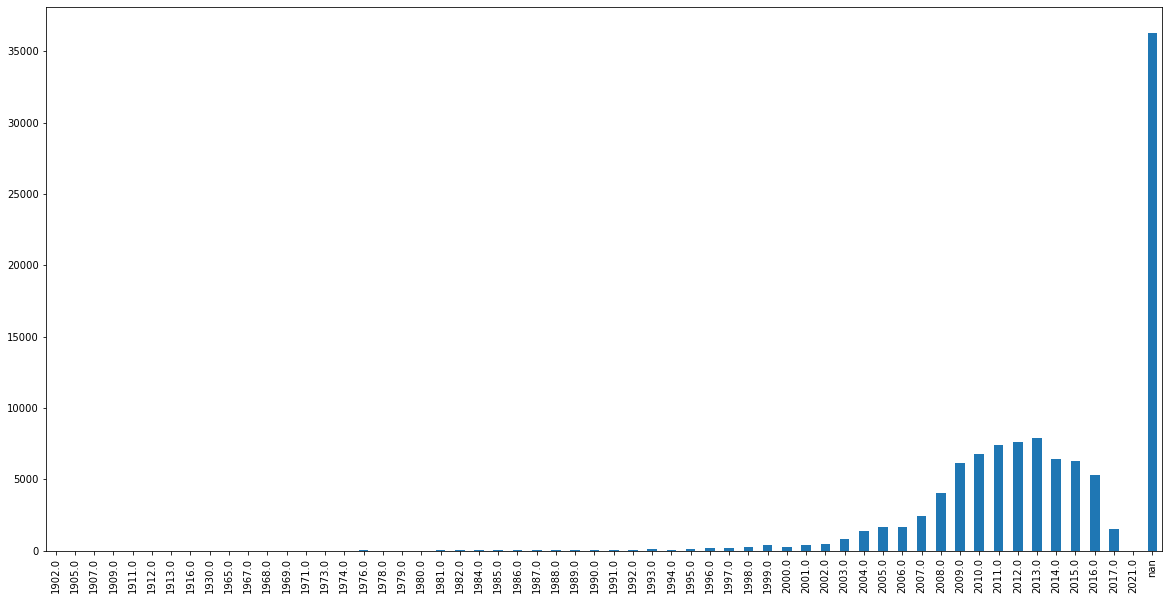

In [13]:
df.ALBUM_date_released_year.value_counts(dropna=False).sort_index().plot(kind='bar')

<AxesSubplot:>

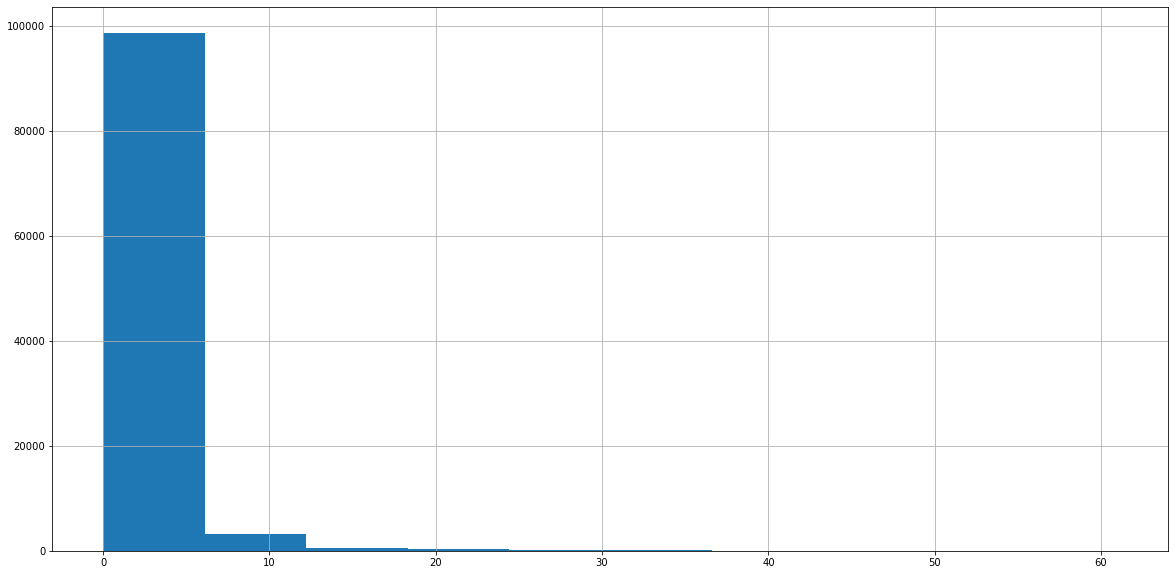

In [14]:
df.ALBUM_favorites.hist()

<AxesSubplot:>

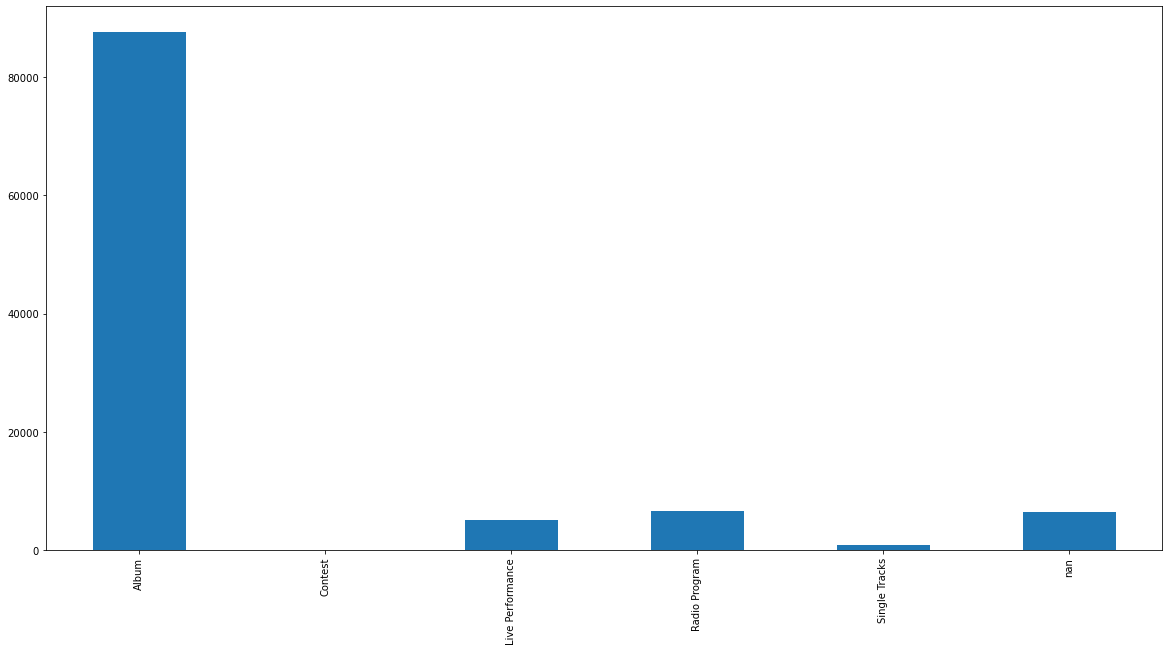

In [15]:
df.ALBUM_type.value_counts(dropna=False).sort_index().plot(kind='bar')
#i valori nan li riampiazzo con Album

<AxesSubplot:>

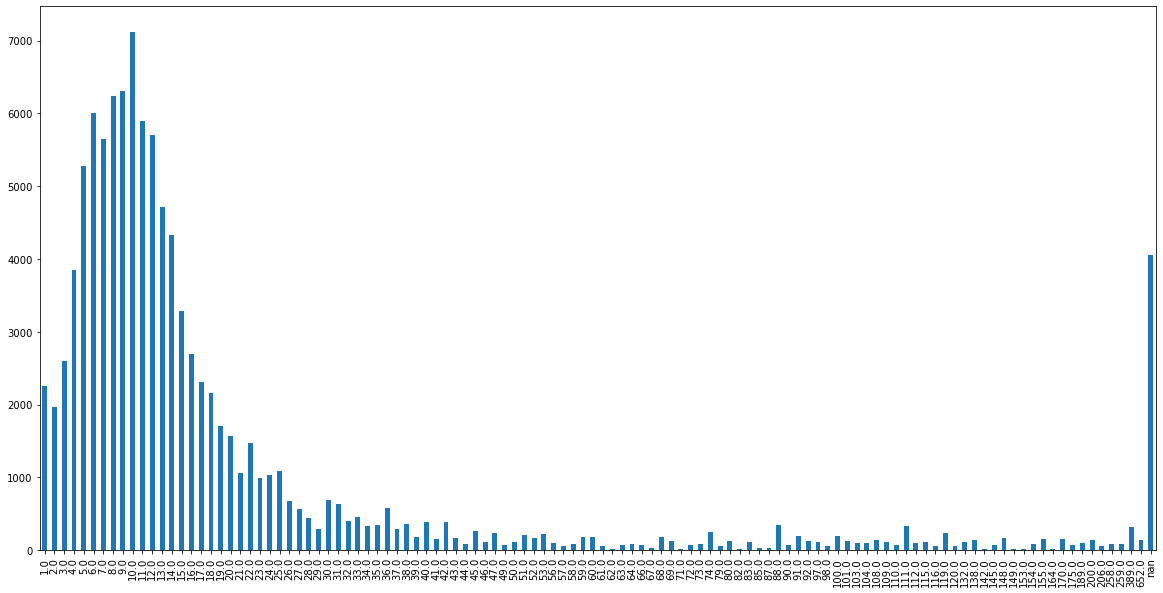

In [16]:
df.ALBUM_tracks.value_counts(dropna=False).sort_index().plot(kind='bar')

<AxesSubplot:>

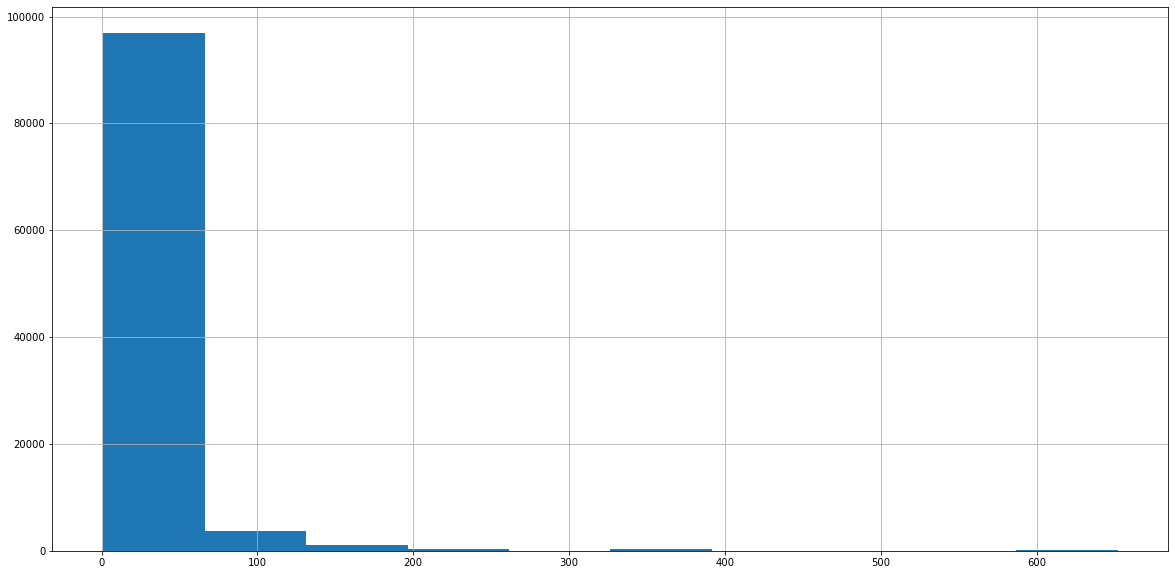

In [17]:
df.ALBUM_tracks.hist()

<AxesSubplot:>

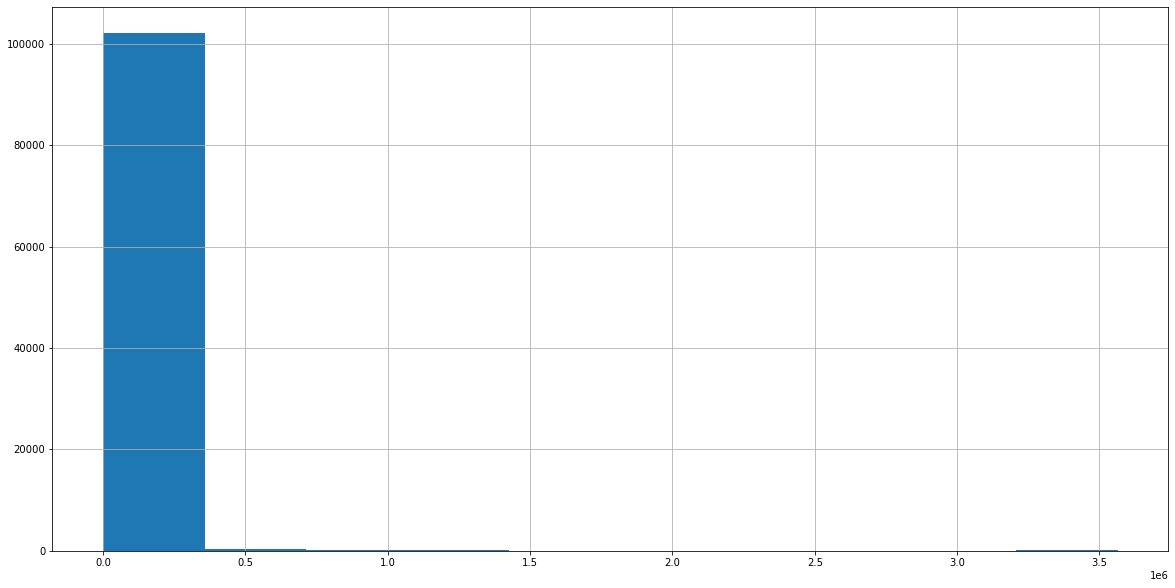

In [18]:
df.ALBUM_listens.hist()

<AxesSubplot:>

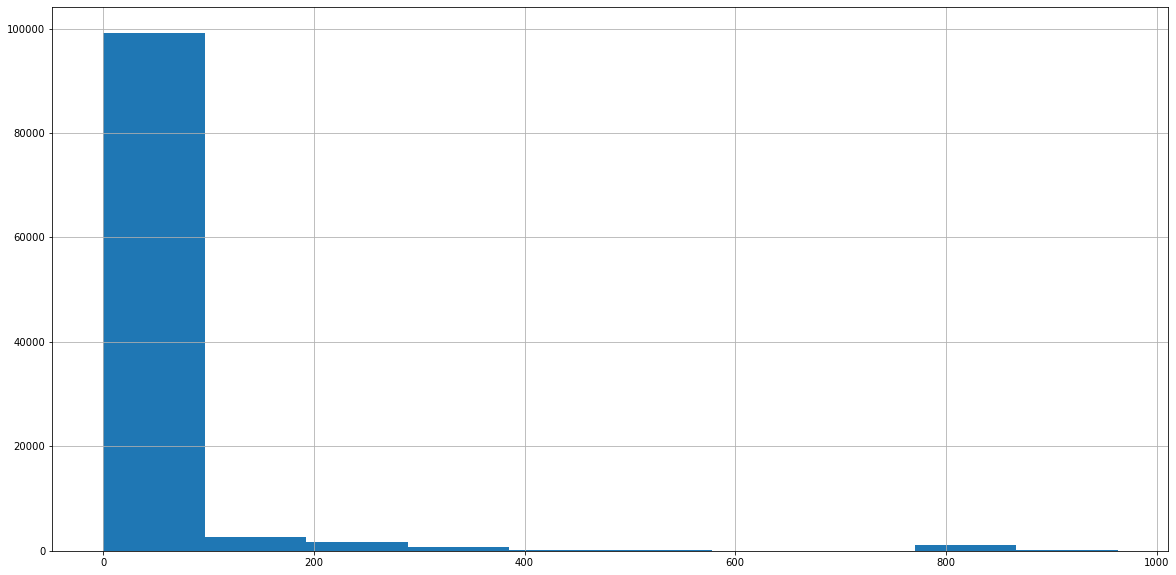

In [19]:
df.ARTIST_favorites.hist()

<AxesSubplot:>

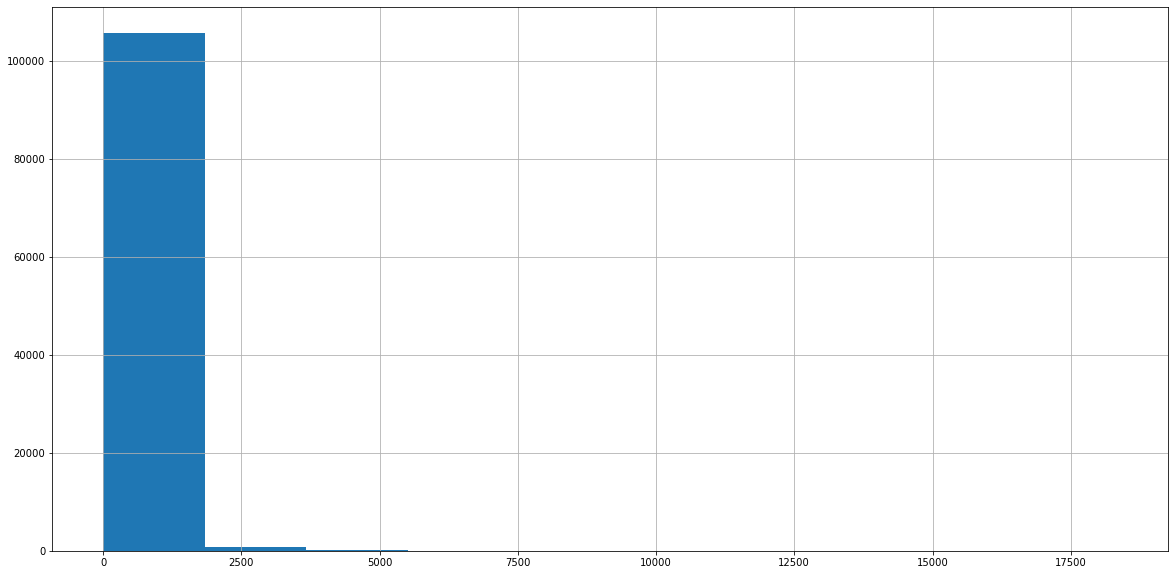

In [20]:
df.TRACK_duration.hist()

<AxesSubplot:>

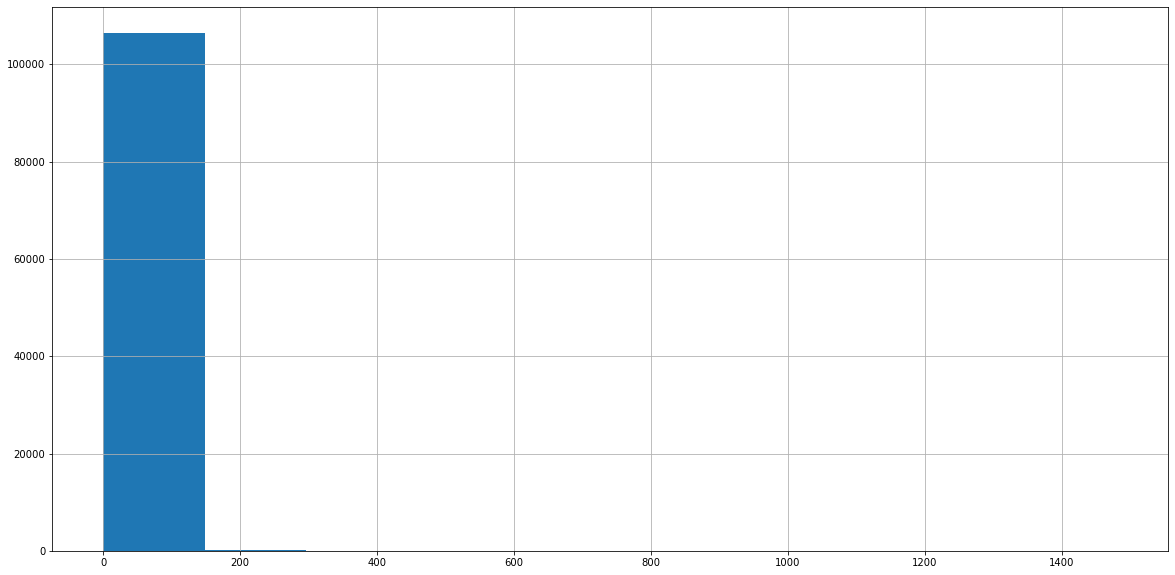

In [21]:
df.TRACK_favorites.hist()

<AxesSubplot:>

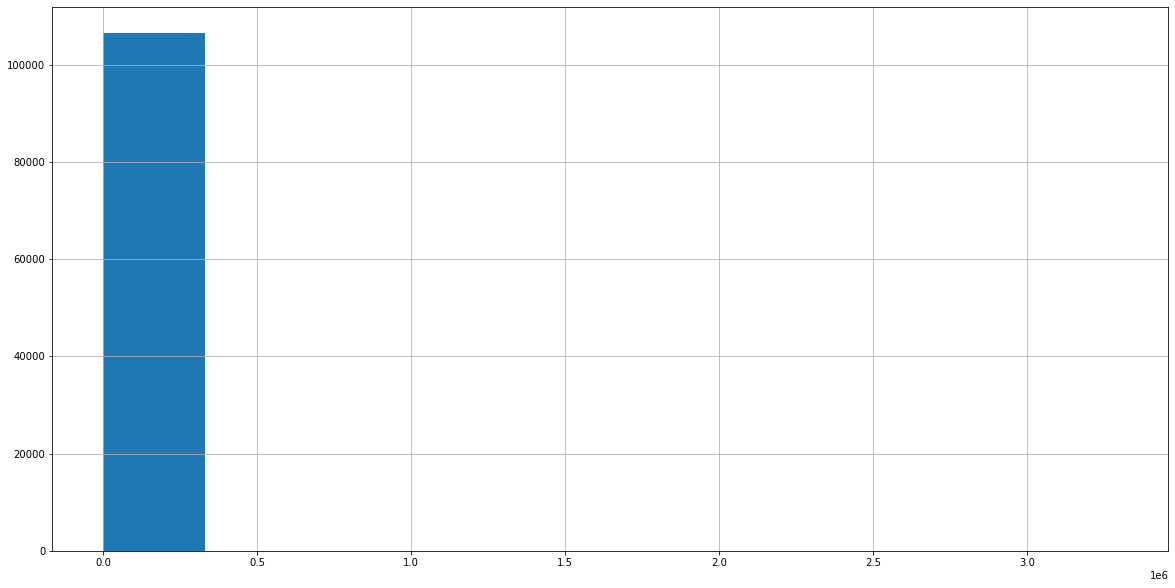

In [22]:
df.TRACK_interest.hist()

<AxesSubplot:>

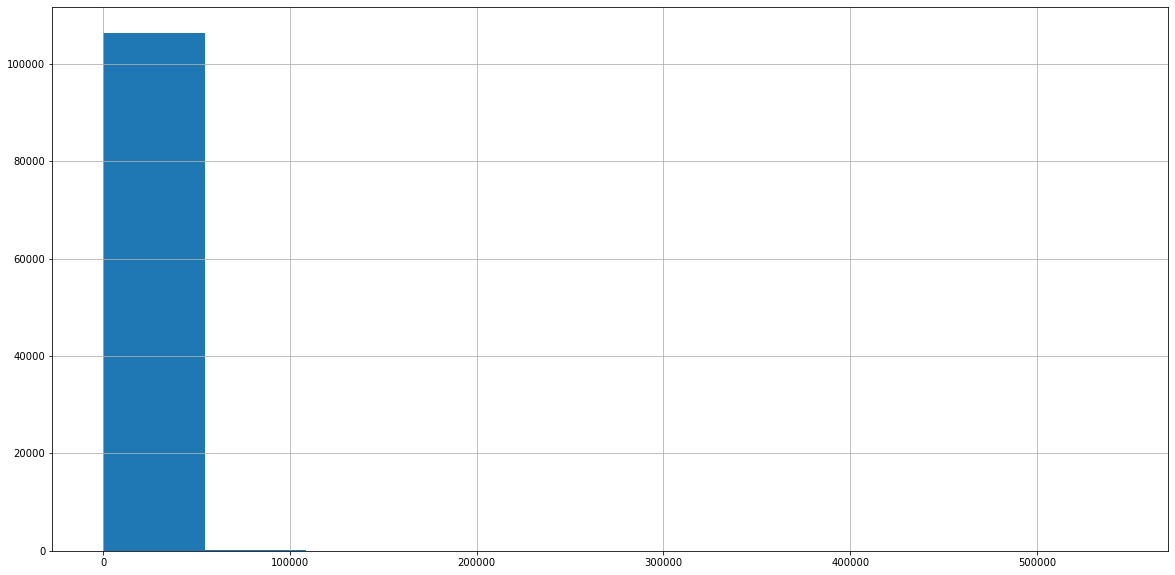

In [23]:
df.TRACK_listens.hist()

### normalizzazione di BitRate

In [24]:
bins_bitrate = np.array([8000, 16000, 24000, 32000, 40000, 48000, 56000, 64000, 80000, 96000,
                  112000, 128000, 144000, 160000, 192000, 224000, 256000, 320000])

In [25]:
centers = (bins_bitrate[1:]+bins_bitrate[:-1])/2

df.TRACK_bitrate = bins_bitrate[np.digitize(df.TRACK_bitrate, centers)]

<AxesSubplot:>

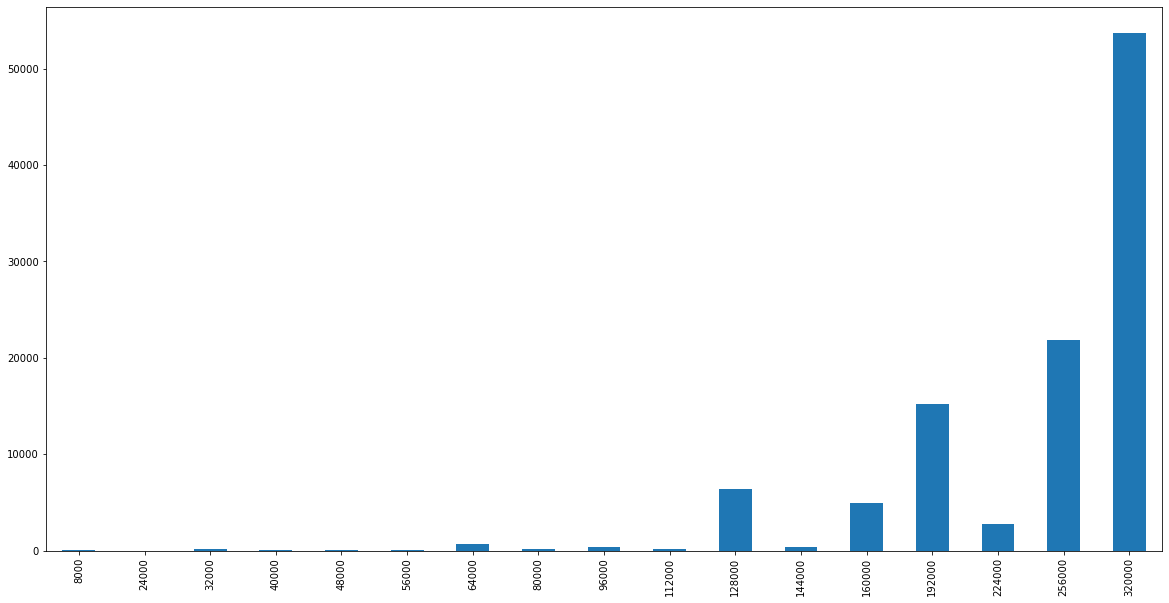

In [26]:
df.TRACK_bitrate.value_counts().sort_index().plot(kind="bar")

# Valori nulli

In [27]:
"""ARTIST_favorites_                0
ALBUM_tracks_                    0
ALBUM_listens_                   0
ALBUM_favorites_                 0
ALBUM_type_                      0
ALBUM_date_released_year_        0"""

'ARTIST_favorites_                0\nALBUM_tracks_                    0\nALBUM_listens_                   0\nALBUM_favorites_                 0\nALBUM_type_                      0\nALBUM_date_released_year_        0'

In [28]:
df.isna().sum()

ALBUM_date_released         36280
ALBUM_date_released_year    36280
ALBUM_favorites              3529
ALBUM_type                   6508
ALBUM_tags                      0
                            ...  
zcrmedian01                     0
zcrmin01                        0
zcrskew01                       0
zcrstd01                        0
TRACK_genres_soloTop         2231
Length: 544, dtype: int64

In [74]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Valori nulli:
- ARTIST_favorites [856]: alta correlazione con ALBUM_favorites, TRACK_favorites, TRACK_listens. Lo rimpiazziamo con la mediana (5)
- ALBUM_tracks [3529], ALBUM_listens [3529] e ALBUM_favorites [3529]: mancano tutte le informazioni sull'album (sono singoli?). Buttiamo via questi record, non c'è modo di ricostruire i valori. (nemmeno provando a recuperare le informazioni con max(TRACK_number) groupby(ALBUM_title))
- ALBUM_type [6508]: la classe di maggioranza -Album- ha c.a. 87k (85%). Si sceglie di settare i valori nulli ad Album
- ALBUM_date_released_year [36280]: il genere non discrimina l'anno
- TRACK_genre_top [56976]: 


Non trattati, per scopi futuri:
- TRACK_genres_soloTop [2231]: Potremmo recuperare al più 733 (< 1%) di generi dal tag. Lo tratteremo come bitmap di tutti 0
- ARTIST_location [36364]: 

### ARTIST_favorites

In [30]:
df["ARTIST_favorites_"] = df.ARTIST_favorites.fillna(df.ARTIST_favorites.median())

<AxesSubplot:>

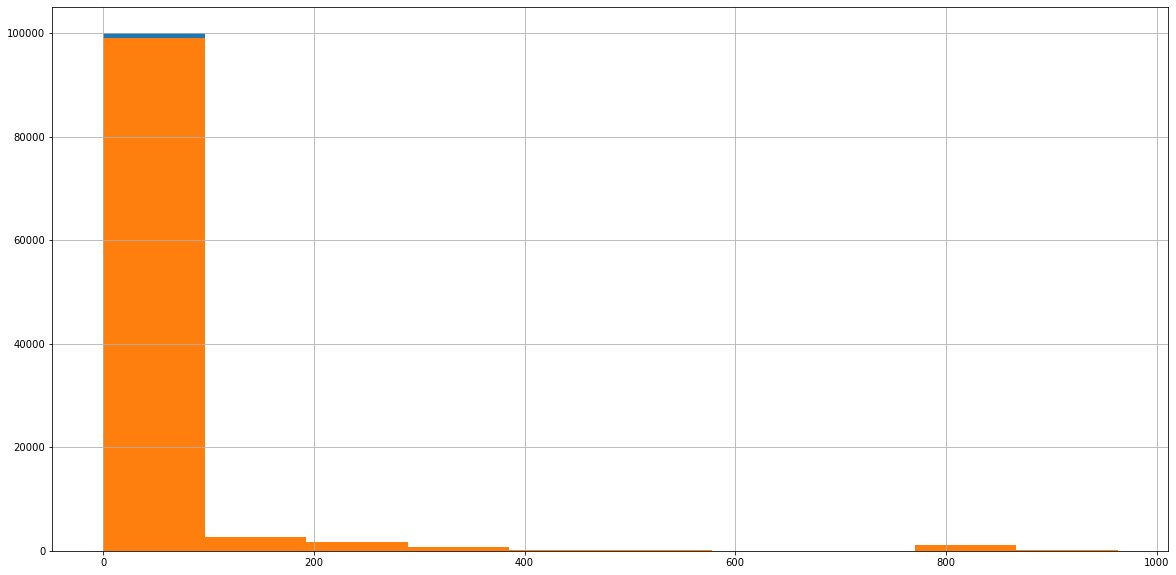

In [31]:
df.ARTIST_favorites_.hist(bins=10)
df.ARTIST_favorites.hist(bins=10)

### ALBUM_tracks

In [32]:
df.groupby(['ALBUM_title'])['TRACK_number'].agg(["max", "count"])

,max,count
ALBUM_title,,
"""...Through The Cracks"" Mix Vol. 1",1,4
"""...when my heart's fire rages out of control...""",18,18
"""32 Ford""",1,1
"""A.B.A.Y.A.M""",1,1
"""Aeroplanes""",1,1
...,...,...
ロッコ,8,8
章4 : 真っ暗闇の人生 : Volume 1,16,16
章4 : 真っ暗闇の人生 : Volume 2,15,15


In [33]:
def fun_temp(x):
    return x.fillna(x.max())

df['ALBUM_tracks_'] = df.groupby(['ALBUM_title'])['TRACK_number'].apply(fun_temp)

In [34]:
df['ALBUM_tracks_'].isna().sum()

1025

### ALBUM_listens

In [35]:
df.groupby(['ALBUM_title'])['TRACK_listens'].agg(["sum", "mean", "count"])

,sum,mean,count
ALBUM_title,,,
"""...Through The Cracks"" Mix Vol. 1",2966,741.500000,4
"""...when my heart's fire rages out of control...""",17664,981.333333,18
"""32 Ford""",11783,11783.000000,1
"""A.B.A.Y.A.M""",2598,2598.000000,1
"""Aeroplanes""",1787,1787.000000,1
...,...,...,...
ロッコ,42506,5313.250000,8
章4 : 真っ暗闇の人生 : Volume 1,10634,664.625000,16
章4 : 真っ暗闇の人生 : Volume 2,8153,543.533333,15


In [36]:
def fun_temp(x):
    return x.fillna(x.sum())

df['ALBUM_listens_'] = df.groupby(['ALBUM_title'])['TRACK_listens'].apply(fun_temp)

In [37]:
df['ALBUM_listens_'].isna().sum()

1025

### ALBUM_favorites

In [38]:
df.groupby(['ALBUM_title'])['TRACK_favorites'].agg(["mean", "count", "sum"])

,mean,count,sum
ALBUM_title,,,
"""...Through The Cracks"" Mix Vol. 1",0.000000,4,0
"""...when my heart's fire rages out of control...""",0.333333,18,6
"""32 Ford""",14.000000,1,14
"""A.B.A.Y.A.M""",6.000000,1,6
"""Aeroplanes""",3.000000,1,3
...,...,...,...
ロッコ,9.000000,8,72
章4 : 真っ暗闇の人生 : Volume 1,0.687500,16,11
章4 : 真っ暗闇の人生 : Volume 2,0.333333,15,5


In [39]:
def fun_temp(x):
    return x.fillna(math.ceil(x.mean()))

df['ALBUM_favorites_'] = df.groupby(['ALBUM_title'])['TRACK_favorites'].apply(fun_temp)

In [40]:
df['ALBUM_favorites_'].isna().sum()

1025

### ALBUM_type

In [41]:
df["ALBUM_type_"] = df.ALBUM_type.fillna("Album")

In [42]:
df["ALBUM_type_"].unique()

array(['Album', 'Single Tracks', 'Live Performance', 'Radio Program',
       'Contest'], dtype=object)

### ALBUM_date_released_year

In [43]:
df.groupby(['TRACK_bitrate'])['ALBUM_date_released_year'].agg(["mean", "count", "median"])

,mean,count,median
TRACK_bitrate,,,
8000,NaN,0,NaN
24000,2013.000000,1,2013.0
32000,2011.923077,65,2013.0
40000,1994.500000,6,2012.0
48000,2012.500000,2,2012.5
56000,2002.312500,16,1998.0
64000,2003.743142,401,2006.0
80000,2011.027027,37,2012.0
96000,2005.666667,84,2009.0


In [44]:
def fun_temp(x):
    return x.fillna(x.median())

df['ALBUM_date_released_year_'] = df.groupby(['TRACK_bitrate'])['ALBUM_date_released_year'].apply(fun_temp)

In [45]:
df['ALBUM_date_released_year_'].isna().sum()

13

In [46]:
df.dropna(subset=["ALBUM_date_released_year_"], inplace=True)

In [47]:
df['ALBUM_date_released_year_'].isna().sum()

0

In [48]:
df.isna().sum()

ALBUM_date_released          36267
ALBUM_date_released_year     36267
ALBUM_favorites               3529
ALBUM_type                    6508
ALBUM_tags                       0
                             ...  
ALBUM_tracks_                 1025
ALBUM_listens_                1025
ALBUM_favorites_              1025
ALBUM_type_                      0
ALBUM_date_released_year_        0
Length: 550, dtype: int64

In [49]:
df.dropna(subset=["ALBUM_tracks_"], inplace=True)
df.dropna(subset=["TRACK_title"], inplace=True)
df.drop(columns=["TRACK_license", "ALBUM_date_released"], inplace=True)

## Creazione boolean generi

In [50]:
df0 = pd.get_dummies(df["TRACK_genres_soloTop"].explode(), prefix_sep='=')
df = pd.concat([df, df0], axis=1)

In [51]:
df.head()

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,chroma_censkurtosis01,chroma_censkurtosis02,chroma_censkurtosis03,chroma_censkurtosis04,chroma_censkurtosis05,chroma_censkurtosis06,chroma_censkurtosis07,chroma_censkurtosis08,chroma_censkurtosis09,chroma_censkurtosis10,chroma_censkurtosis11,chroma_censkurtosis12,chroma_censmax01,chroma_censmax02,chroma_censmax03,chroma_censmax04,chroma_censmax05,chroma_censmax06,chroma_censmax07,chroma_censmax08,chroma_censmax09,chroma_censmax10,chroma_censmax11,chroma_censmax12,chroma_censmean01,chroma_censmean02,chroma_censmean03,chroma_censmean04,chroma_censmean05,chroma_censmean06,chroma_censmean07,chroma_censmean08,chroma_censmean09,chroma_censmean10,chroma_censmean11,chroma_censmean12,chroma_censmedian01,chroma_censmedian02,chroma_censmedian03,chroma_censmedian04,chroma_censmedian05,chroma_censmedian06,chroma_censmedian07,chroma_censmedian08,chroma_censmedian09,chroma_censmedian10,chroma_censmedian11,chroma_censmedian12,chroma_censmin01,chroma_censmin02,chroma_censmin03,chroma_censmin04,chroma_censmin05,chroma_censmin06,chroma_censmin07,chroma_censmin08,chroma_censmin09,chroma_censmin10,chroma_censmin11,chroma_censmin12,chroma_censskew01,chroma_censskew02,chroma_censskew03,chroma_censskew04,chroma_censskew05,chroma_censskew06,chroma_censskew07,chroma_censskew08,chroma_censskew09,chroma_censskew10,chroma_censskew11,chroma_censskew12,chroma_censstd01,chroma_censstd02,chroma_censstd03,chroma_censstd04,chroma_censstd05,chroma_censstd06,chroma_censstd07,chroma_censstd08,chroma_censstd09,chroma_censstd10,chroma_censstd11,chroma_censstd12,chroma_cqtkurtosis01,chroma_cqtkurtosis02,chroma_cqtkurtosis03,chroma_cqtkurtosis04,chroma_cqtkurtosis05,chroma_cqtkurtosis06,chroma_cqtkurtosis07,chroma_cqtkurtosis08,chroma_cqtkurtosis09,chroma_cqtkurtosis10,chroma_cqtkurtosis11,chroma_cqtkurtosis12,chroma_cqtmax01,chroma_cqtmax02,chroma_cqtmax03,chroma_cqtmax04,chroma_cqtmax05,chroma_cqtmax06,chroma_cqtmax07,chroma_cqtmax08,chroma_cqtmax09,chroma_cqtmax10,chroma_cqtmax11,chroma_cqtmax12,chroma_cqtmean01,chroma_cqtmean02,chroma_cqtmean03,chroma_cqtmean04,chroma_cqtmean05,chroma_cqtmean06,chroma_cqtmean07,chroma_cqtmean08,chroma_cqtmean09,chroma_cqtmean10,chroma_cqtmean11,chroma_cqtmean12,chroma_cqtmedian01,chroma_cqtmedian02,chroma_cqtmedian03,chroma_cqtmedian04,chroma_cqtmedian05,chroma_cqtmedian06,chroma_cqtmedian07,chroma_cqtmedian08,chroma_cqtmedian09,chroma_cqtmedian10,chroma_cqtmedian11,chroma_cqtmedian12,chroma_cqtmin01,chroma_cqtmin02,chroma_cqtmin03,chroma_cqtmin04,chroma_cqtmin05,chroma_cqtmin06,chroma_cqtmin07,chroma_cqtmin08,chroma_cqtmin09,chroma_cqtmin10,chroma_cqtmin11,chroma_cqtmin12,chroma_cqtskew01,chroma_cqtskew02,chroma_cqtskew03,chroma_cqtskew04,chroma_cqtskew05,chroma_cqtskew06,chroma_cqtskew07,chroma_cqtskew08,chroma_cqtskew09,chroma_cqtskew10,chroma_cqtskew11,chroma_cqtskew12,chroma_cqtstd01,chroma_cqtstd02,chroma_cqtstd03,chroma_cqtstd04,chroma_cqtstd05,chroma_cqtstd06,chroma_cqtstd07,chroma_cqtstd08,chroma_cqtstd09,chroma_cqtstd10,chroma_cqtstd11,chroma_cqtstd12,chroma_stftkurtosis01,chroma_stftkurtosis02,chroma_stftkurtosis03,chroma_stftkurtosis04,chroma_stftkurtosis05,chroma_stftkurtosis06,chroma_stftkurtosis07,chroma_stftkurtosis08,chroma_stftkurtosis09,chroma_stftkurtosis10,chroma_stftkurtosis11,chroma_stftkurtosis12,chroma_stftmax01,chroma_stftmax02,chroma_stftmax03,chroma_stftmax04,chroma_stftmax05,chroma_stftmax06,chroma_stftmax07,chroma_stftmax08,chroma_stftmax09,chroma_stftmax10,chroma_stftmax11,chroma_stftmax12,chroma_stftmean01,chroma_stftmean02,chroma_stftmean03,chroma_stftmean04,chroma_stftmean05,chroma_stftmean06,chroma_stftmean07,chroma_stftmean08,chroma_stftmean09,chroma_stftmean10,chroma_stftme

## Features reduction

In [52]:
df.head()

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,chroma_censkurtosis01,chroma_censkurtosis02,chroma_censkurtosis03,chroma_censkurtosis04,chroma_censkurtosis05,chroma_censkurtosis06,chroma_censkurtosis07,chroma_censkurtosis08,chroma_censkurtosis09,chroma_censkurtosis10,chroma_censkurtosis11,chroma_censkurtosis12,chroma_censmax01,chroma_censmax02,chroma_censmax03,chroma_censmax04,chroma_censmax05,chroma_censmax06,chroma_censmax07,chroma_censmax08,chroma_censmax09,chroma_censmax10,chroma_censmax11,chroma_censmax12,chroma_censmean01,chroma_censmean02,chroma_censmean03,chroma_censmean04,chroma_censmean05,chroma_censmean06,chroma_censmean07,chroma_censmean08,chroma_censmean09,chroma_censmean10,chroma_censmean11,chroma_censmean12,chroma_censmedian01,chroma_censmedian02,chroma_censmedian03,chroma_censmedian04,chroma_censmedian05,chroma_censmedian06,chroma_censmedian07,chroma_censmedian08,chroma_censmedian09,chroma_censmedian10,chroma_censmedian11,chroma_censmedian12,chroma_censmin01,chroma_censmin02,chroma_censmin03,chroma_censmin04,chroma_censmin05,chroma_censmin06,chroma_censmin07,chroma_censmin08,chroma_censmin09,chroma_censmin10,chroma_censmin11,chroma_censmin12,chroma_censskew01,chroma_censskew02,chroma_censskew03,chroma_censskew04,chroma_censskew05,chroma_censskew06,chroma_censskew07,chroma_censskew08,chroma_censskew09,chroma_censskew10,chroma_censskew11,chroma_censskew12,chroma_censstd01,chroma_censstd02,chroma_censstd03,chroma_censstd04,chroma_censstd05,chroma_censstd06,chroma_censstd07,chroma_censstd08,chroma_censstd09,chroma_censstd10,chroma_censstd11,chroma_censstd12,chroma_cqtkurtosis01,chroma_cqtkurtosis02,chroma_cqtkurtosis03,chroma_cqtkurtosis04,chroma_cqtkurtosis05,chroma_cqtkurtosis06,chroma_cqtkurtosis07,chroma_cqtkurtosis08,chroma_cqtkurtosis09,chroma_cqtkurtosis10,chroma_cqtkurtosis11,chroma_cqtkurtosis12,chroma_cqtmax01,chroma_cqtmax02,chroma_cqtmax03,chroma_cqtmax04,chroma_cqtmax05,chroma_cqtmax06,chroma_cqtmax07,chroma_cqtmax08,chroma_cqtmax09,chroma_cqtmax10,chroma_cqtmax11,chroma_cqtmax12,chroma_cqtmean01,chroma_cqtmean02,chroma_cqtmean03,chroma_cqtmean04,chroma_cqtmean05,chroma_cqtmean06,chroma_cqtmean07,chroma_cqtmean08,chroma_cqtmean09,chroma_cqtmean10,chroma_cqtmean11,chroma_cqtmean12,chroma_cqtmedian01,chroma_cqtmedian02,chroma_cqtmedian03,chroma_cqtmedian04,chroma_cqtmedian05,chroma_cqtmedian06,chroma_cqtmedian07,chroma_cqtmedian08,chroma_cqtmedian09,chroma_cqtmedian10,chroma_cqtmedian11,chroma_cqtmedian12,chroma_cqtmin01,chroma_cqtmin02,chroma_cqtmin03,chroma_cqtmin04,chroma_cqtmin05,chroma_cqtmin06,chroma_cqtmin07,chroma_cqtmin08,chroma_cqtmin09,chroma_cqtmin10,chroma_cqtmin11,chroma_cqtmin12,chroma_cqtskew01,chroma_cqtskew02,chroma_cqtskew03,chroma_cqtskew04,chroma_cqtskew05,chroma_cqtskew06,chroma_cqtskew07,chroma_cqtskew08,chroma_cqtskew09,chroma_cqtskew10,chroma_cqtskew11,chroma_cqtskew12,chroma_cqtstd01,chroma_cqtstd02,chroma_cqtstd03,chroma_cqtstd04,chroma_cqtstd05,chroma_cqtstd06,chroma_cqtstd07,chroma_cqtstd08,chroma_cqtstd09,chroma_cqtstd10,chroma_cqtstd11,chroma_cqtstd12,chroma_stftkurtosis01,chroma_stftkurtosis02,chroma_stftkurtosis03,chroma_stftkurtosis04,chroma_stftkurtosis05,chroma_stftkurtosis06,chroma_stftkurtosis07,chroma_stftkurtosis08,chroma_stftkurtosis09,chroma_stftkurtosis10,chroma_stftkurtosis11,chroma_stftkurtosis12,chroma_stftmax01,chroma_stftmax02,chroma_stftmax03,chroma_stftmax04,chroma_stftmax05,chroma_stftmax06,chroma_stftmax07,chroma_stftmax08,chroma_stftmax09,chroma_stftmax10,chroma_stftmax11,chroma_stftmax12,chroma_stftmean01,chroma_stftmean02,chroma_stftmean03,chroma_stftmean04,chroma_stftmean05,chroma_stftmean06,chroma_stftmean07,chroma_stftmean08,chroma_stftmean09,chroma_stftmean10,chroma_stftme

In [53]:
chroma_censkurtosis = ["chroma_censkurtosis01",	"chroma_censkurtosis02","chroma_censkurtosis03","chroma_censkurtosis04","chroma_censkurtosis05","chroma_censkurtosis06","chroma_censkurtosis07","chroma_censkurtosis08","chroma_censkurtosis09","chroma_censkurtosis10","chroma_censkurtosis11","chroma_censkurtosis12"]
chroma_censmax = ["chroma_censmax01	chroma_censmax02","chroma_censmax03","chroma_censmax04","chroma_censmax05","chroma_censmax06","chroma_censmax07","chroma_censmax08","chroma_censmax09","chroma_censmax10","chroma_censmax11","chroma_censmax12"]
chroma_censmean = ["chroma_censmean01","chroma_censmean02","chroma_censmean03","chroma_censmean04","chroma_censmean05","chroma_censmean06","chroma_censmean07","chroma_censmean08","chroma_censmean09","chroma_censmean10","chroma_censmean11","chroma_censmean12"]
chroma_censmedian = ["chroma_censmedian01","chroma_censmedian02","chroma_censmedian03","chroma_censmedian04","chroma_censmedian05","chroma_censmedian06","chroma_censmedian07","chroma_censmedian08","chroma_censmedian09","chroma_censmedian10","chroma_censmedian11","chroma_censmedian12"]
chroma_censmin = ["chroma_censmin01	chroma_censmin02","chroma_censmin03","chroma_censmin04","chroma_censmin05","chroma_censmin06","chroma_censmin07","chroma_censmin08","chroma_censmin09","chroma_censmin10","chroma_censmin11","chroma_censmin12"]
chroma_censskew = ['chroma_censskew01','chroma_censskew02','chroma_censskew03','chroma_censskew04','chroma_censskew05','chroma_censskew06','chroma_censskew07','chroma_censskew08','chroma_censskew09','chroma_censskew10','chroma_censskew11','chroma_censskew12']
chroma_censstd = ['chroma_censstd01', 'chroma_censstd02', 'chroma_censstd03', 'chroma_censstd04', 'chroma_censstd05', 'chroma_censstd06', 'chroma_censstd07', 'chroma_censstd08', 'chroma_censstd09', 'chroma_censstd10', 'chroma_censstd11', 'chroma_censstd12']

chroma_censcqtkurtosis = ['chroma_cqtkurtosis01', 'chroma_cqtkurtosis02', 'chroma_cqtkurtosis03', 'chroma_cqtkurtosis04', 'chroma_cqtkurtosis05', 'chroma_cqtkurtosis06', 'chroma_cqtkurtosis07', 'chroma_cqtkurtosis08', 'chroma_cqtkurtosis09', 'chroma_cqtkurtosis10', 'chroma_cqtkurtosis11', 'chroma_cqtkurtosis12']
chroma_cqtmax = ['chroma_cqtmax01', 'chroma_cqtmax02', 'chroma_cqtmax03', 'chroma_cqtmax04', 'chroma_cqtmax05', 'chroma_cqtmax06', 'chroma_cqtmax07', 'chroma_cqtmax08', 'chroma_cqtmax09', 'chroma_cqtmax10', 'chroma_cqtmax11', 'chroma_cqtmax12']
chroma_cqtmean = ['chroma_cqtmean01', 'chroma_cqtmean02', 'chroma_cqtmean03', 'chroma_cqtmean04', 'chroma_cqtmean05', 'chroma_cqtmean06', 'chroma_cqtmean07', 'chroma_cqtmean08', 'chroma_cqtmean09', 'chroma_cqtmean10', 'chroma_cqtmean11', 'chroma_cqtmean12']
chroma_cqtmedian = ['chroma_cqtmedian01', 'chroma_cqtmedian02', 'chroma_cqtmedian03', 'chroma_cqtmedian04', 'chroma_cqtmedian05', 'chroma_cqtmedian06', 'chroma_cqtmedian07', 'chroma_cqtmedian08', 'chroma_cqtmedian09', 'chroma_cqtmedian10', 'chroma_cqtmedian11', 'chroma_cqtmedian12']
chroma_cqtmin = ['chroma_cqtmin01', 'chroma_cqtmin02', 'chroma_cqtmin03', 'chroma_cqtmin04', 'chroma_cqtmin05', 'chroma_cqtmin06', 'chroma_cqtmin07', 'chroma_cqtmin08', 'chroma_cqtmin09', 'chroma_cqtmin10', 'chroma_cqtmin11', 'chroma_cqtmin12']
chroma_cqtskew = ['chroma_cqtskew01', 'chroma_cqtskew02', 'chroma_cqtskew03', 'chroma_cqtskew04', 'chroma_cqtskew05', 'chroma_cqtskew06', 'chroma_cqtskew07', 'chroma_cqtskew08', 'chroma_cqtskew09', 'chroma_cqtskew10', 'chroma_cqtskew11', 'chroma_cqtskew12']
chroma_cqtstd = ['chroma_cqtstd01', 'chroma_cqtstd02', 'chroma_cqtstd03', 'chroma_cqtstd04', 'chroma_cqtstd05', 'chroma_cqtstd06', 'chroma_cqtstd07', 'chroma_cqtstd08', 'chroma_cqtstd09', 'chroma_cqtstd10', 'chroma_cqtstd11', 'chroma_cqtstd12']

chroma_stftkurtosis = ['chroma_stftkurtosis01', 'chroma_stftkurtosis02', 'chroma_stftkurtosis03', 'chroma_stftkurtosis04', 'chroma_stftkurtosis05', 'chroma_stftkurtosis06', 'chroma_stftkurtosis07', 'chroma_stftkurtosis08', 'chroma_stftkurtosis09', 'chroma_stftkurtosis10', 'chroma_stftkurtosis11', 'chroma_stftkurtosis12']
chroma_stftmax = ['chroma_stftmax01', 'chroma_stftmax02', 'chroma_stftmax03', 'chroma_stftmax04', 'chroma_stftmax05', 'chroma_stftmax06', 'chroma_stftmax07', 'chroma_stftmax08', 'chroma_stftmax09', 'chroma_stftmax10', 'chroma_stftmax11', 'chroma_stftmax12']
chroma_stftmean = ['chroma_stftmean01', 'chroma_stftmean02', 'chroma_stftmean03', 'chroma_stftmean04', 'chroma_stftmean05', 'chroma_stftmean06', 'chroma_stftmean07', 'chroma_stftmean08', 'chroma_stftmean09', 'chroma_stftmean10', 'chroma_stftmean11', 'chroma_stftmean12']
chroma_stftmedian = ['chroma_stftmedian01', 'chroma_stftmedian02', 'chroma_stftmedian03', 'chroma_stftmedian04', 'chroma_stftmedian05', 'chroma_stftmedian06', 'chroma_stftmedian07', 'chroma_stftmedian08', 'chroma_stftmedian09', 'chroma_stftmedian10', 'chroma_stftmedian11', 'chroma_stftmedian12']
chroma_stftmin = ['chroma_stftmin01', 'chroma_stftmin02', 'chroma_stftmin03', 'chroma_stftmin04', 'chroma_stftmin05', 'chroma_stftmin06', 'chroma_stftmin07', 'chroma_stftmin08', 'chroma_stftmin09', 'chroma_stftmin10', 'chroma_stftmin11', 'chroma_stftmin12']
chroma_stftskew = ['chroma_stftskew01', 'chroma_stftskew02', 'chroma_stftskew03', 'chroma_stftskew04', 'chroma_stftskew05', 'chroma_stftskew06', 'chroma_stftskew07', 'chroma_stftskew08', 'chroma_stftskew09', 'chroma_stftskew10', 'chroma_stftskew11', 'chroma_stftskew12']
chroma_stftstd = ['chroma_stftstd01', 'chroma_stftstd02', 'chroma_stftstd03', 'chroma_stftstd04', 'chroma_stftstd05', 'chroma_stftstd06', 'chroma_stftstd07', 'chroma_stftstd08', 'chroma_stftstd09', 'chroma_stftstd10', 'chroma_stftstd11', 'chroma_stftstd12']

mfcckurtosis = ['mfcckurtosis01', 'mfcckurtosis02', 'mfcckurtosis03', 'mfcckurtosis04', 'mfcckurtosis05', 'mfcckurtosis06', 'mfcckurtosis07', 'mfcckurtosis08', 'mfcckurtosis09', 'mfcckurtosis10', 'mfcckurtosis11', 'mfcckurtosis12', 'mfcckurtosis13', 'mfcckurtosis14', 'mfcckurtosis15', 'mfcckurtosis16', 'mfcckurtosis17', 'mfcckurtosis18', 'mfcckurtosis19', 'mfcckurtosis20']
mfccmax = ['mfccmax01', 'mfccmax02', 'mfccmax03', 'mfccmax04', 'mfccmax05', 'mfccmax06', 'mfccmax07', 'mfccmax08', 'mfccmax09', 'mfccmax10', 'mfccmax11', 'mfccmax12', 'mfccmax13', 'mfccmax14', 'mfccmax15', 'mfccmax16', 'mfccmax17', 'mfccmax18', 'mfccmax19', 'mfccmax20']
mfccmean = ['mfccmean01', 'mfccmean02', 'mfccmean03', 'mfccmean04', 'mfccmean05', 'mfccmean06', 'mfccmean07', 'mfccmean08', 'mfccmean09', 'mfccmean10', 'mfccmean11', 'mfccmean12', 'mfccmean13', 'mfccmean14', 'mfccmean15', 'mfccmean16', 'mfccmean17', 'mfccmean18', 'mfccmean19', 'mfccmean20']
mfccmedian = ['mfccmedian01', 'mfccmedian02', 'mfccmedian03', 'mfccmedian04', 'mfccmedian05', 'mfccmedian06', 'mfccmedian07', 'mfccmedian08', 'mfccmedian09', 'mfccmedian10', 'mfccmedian11', 'mfccmedian12', 'mfccmedian13', 'mfccmedian14', 'mfccmedian15', 'mfccmedian16', 'mfccmedian17', 'mfccmedian18', 'mfccmedian19', 'mfccmedian20']
mfccmin = ['mfccmin01', 'mfccmin02', 'mfccmin03', 'mfccmin04', 'mfccmin05', 'mfccmin06', 'mfccmin07', 'mfccmin08', 'mfccmin09', 'mfccmin10', 'mfccmin11', 'mfccmin12', 'mfccmin13', 'mfccmin14', 'mfccmin15', 'mfccmin16', 'mfccmin17', 'mfccmin18', 'mfccmin19', 'mfccmin20']
mfccskew = ['mfccskew01', 'mfccskew02', 'mfccskew03', 'mfccskew04', 'mfccskew05', 'mfccskew06', 'mfccskew07', 'mfccskew08', 'mfccskew09', 'mfccskew10', 'mfccskew11', 'mfccskew12', 'mfccskew13', 'mfccskew14', 'mfccskew15', 'mfccskew16', 'mfccskew17', 'mfccskew18', 'mfccskew19', 'mfccskew20']
mfccstd = ['mfccstd01', 'mfccstd02', 'mfccstd03', 'mfccstd04', 'mfccstd05', 'mfccstd06', 'mfccstd07', 'mfccstd08', 'mfccstd09', 'mfccstd10', 'mfccstd11', 'mfccstd12', 'mfccstd13', 'mfccstd14', 'mfccstd15', 'mfccstd16', 'mfccstd17', 'mfccstd18', 'mfccstd19', 'mfccstd20']

rmsekurtosis = ['rmsekurtosis01'] 
rmsemax = ['rmsemax01']
rmsemean = ['rmsemean01']
rmsemedian = ['rmsemedian01'] 
rmsemin = ['rmsemin01']
rmseskew = ['rmseskew01']
rmsestd = ['rmsestd01']

spectral_bandwidthkurtosis = ['spectral_bandwidthkurtosis01']
spectral_bandwidthmax = ['spectral_bandwidthmax01']
spectral_bandwidthmean = ['spectral_bandwidthmean01']
spectral_bandwidthmedian = ['spectral_bandwidthmedian01']
spectral_bandwidthmin = ['spectral_bandwidthmin01']
spectral_bandwidthskew = ['spectral_bandwidthskew01']
spectral_bandwidthstd = ['spectral_bandwidthstd01']

spectral_centroidkurtosis = ['spectral_centroidkurtosis01']
spectral_centroidmax = ['spectral_centroidmax01']
spectral_centroidmean = ['spectral_centroidmean01']
spectral_centroidmedian = ['spectral_centroidmedian01']
spectral_centroidmin = ['spectral_centroidmin01']
spectral_centroidskew = ['spectral_centroidskew01']
spectral_centroidstd = ['spectral_centroidstd01']

spectral_contrastkurtosis = ['spectral_contrastkurtosis01', 'spectral_contrastkurtosis02', 'spectral_contrastkurtosis03', 'spectral_contrastkurtosis04', 'spectral_contrastkurtosis05', 'spectral_contrastkurtosis06', 'spectral_contrastkurtosis07']
spectral_contrastmax = ['spectral_contrastmax01', 'spectral_contrastmax02', 'spectral_contrastmax03', 'spectral_contrastmax04', 'spectral_contrastmax05', 'spectral_contrastmax06', 'spectral_contrastmax07']
spectral_contrastmean = ['spectral_contrastmean01', 'spectral_contrastmean02', 'spectral_contrastmean03', 'spectral_contrastmean04', 'spectral_contrastmean05', 'spectral_contrastmean06', 'spectral_contrastmean07']
spectral_contrastmedian = ['spectral_contrastmedian01', 'spectral_contrastmedian02', 'spectral_contrastmedian03', 'spectral_contrastmedian04', 'spectral_contrastmedian05', 'spectral_contrastmedian06', 'spectral_contrastmedian07']
spectral_contrastmin = ['spectral_contrastmin01', 'spectral_contrastmin02', 'spectral_contrastmin03', 'spectral_contrastmin04', 'spectral_contrastmin05', 'spectral_contrastmin06', 'spectral_contrastmin07']
spectral_contrastskew = ['spectral_contrastskew01', 'spectral_contrastskew02', 'spectral_contrastskew03', 'spectral_contrastskew04', 'spectral_contrastskew05', 'spectral_contrastskew06', 'spectral_contrastskew07']
spectral_contraststd = ['spectral_contraststd01', 'spectral_contraststd02', 'spectral_contraststd03', 'spectral_contraststd04', 'spectral_contraststd05', 'spectral_contraststd06', 'spectral_contraststd07']

spectral_rolloffkurtosis = ['spectral_rolloffkurtosis01']
spectral_rolloffmax = ['spectral_rolloffmean01']
spectral_rolloffmedian = ['spectral_rolloffmedian01']
spectral_rolloffmin = ['spectral_rolloffmin01']
spectral_rolloffskew = ['spectral_rolloffskew01']
spectral_rolloffstd = ['spectral_rolloffstd01']

tonnetzkurtosis = ['tonnetzkurtosis01', 'tonnetzkurtosis02', 'tonnetzkurtosis03', 'tonnetzkurtosis04', 'tonnetzkurtosis05', 'tonnetzkurtosis06']
tonnetzmax = ['tonnetzmax01', 'tonnetzmax02', 'tonnetzmax03', 'tonnetzmax04', 'tonnetzmax05', 'tonnetzmax06']
tonnetzmean = ['tonnetzmean01', 'tonnetzmean02', 'tonnetzmean03', 'tonnetzmean04', 'tonnetzmean05', 'tonnetzmean06']
tonnetzmedian = ['tonnetzmedian01', 'tonnetzmedian02', 'tonnetzmedian03', 'tonnetzmedian04', 'tonnetzmedian05', 'tonnetzmedian06']
tonnetzmin = ['tonnetzmin01', 'tonnetzmin02', 'tonnetzmin03', 'tonnetzmin04', 'tonnetzmin05', 'tonnetzmin06']
tonnetzskew = ['tonnetzskew01', 'tonnetzskew02', 'tonnetzskew03', 'tonnetzskew04', 'tonnetzskew05', 'tonnetzskew06']
tonnetzstd = ['tonnetzstd01', 'tonnetzstd02', 'tonnetzstd03', 'tonnetzstd04', 'tonnetzstd05', 'tonnetzstd06']

zcrkurtosis = ['zcrkurtosis01']
zcrmax = ['zcrmax01']
zcrmean = ['zcrmean01']
zcrmedian = ['zcrmedian01']
zcrmin = ['zcrmin01']
zcrskew = ['zcrskew01']
zcrstd = ['zcrstd01']

In [54]:
features_map = {
    "chroma_censkurtosis" : ["chroma_censkurtosis01","chroma_censkurtosis02","chroma_censkurtosis03","chroma_censkurtosis04","chroma_censkurtosis05","chroma_censkurtosis06","chroma_censkurtosis07","chroma_censkurtosis08","chroma_censkurtosis09","chroma_censkurtosis10","chroma_censkurtosis11","chroma_censkurtosis12"],
    "chroma_censmax" : ["chroma_censmax01","chroma_censmax02","chroma_censmax03","chroma_censmax04","chroma_censmax05","chroma_censmax06","chroma_censmax07","chroma_censmax08","chroma_censmax09","chroma_censmax10","chroma_censmax11","chroma_censmax12"],
    "chroma_censmean" : ["chroma_censmean01","chroma_censmean02","chroma_censmean03","chroma_censmean04","chroma_censmean05","chroma_censmean06","chroma_censmean07","chroma_censmean08","chroma_censmean09","chroma_censmean10","chroma_censmean11","chroma_censmean12"],
    "chroma_censmedian" : ["chroma_censmedian01","chroma_censmedian02","chroma_censmedian03","chroma_censmedian04","chroma_censmedian05","chroma_censmedian06","chroma_censmedian07","chroma_censmedian08","chroma_censmedian09","chroma_censmedian10","chroma_censmedian11","chroma_censmedian12"],
    "chroma_censmin" : ["chroma_censmin01","chroma_censmin02","chroma_censmin03","chroma_censmin04","chroma_censmin05","chroma_censmin06","chroma_censmin07","chroma_censmin08","chroma_censmin09","chroma_censmin10","chroma_censmin11","chroma_censmin12"],
    "chroma_censskew" : ['chroma_censskew01','chroma_censskew02','chroma_censskew03','chroma_censskew04','chroma_censskew05','chroma_censskew06','chroma_censskew07','chroma_censskew08','chroma_censskew09','chroma_censskew10','chroma_censskew11','chroma_censskew12'],
    "chroma_censstd" : ['chroma_censstd01', 'chroma_censstd02', 'chroma_censstd03', 'chroma_censstd04', 'chroma_censstd05', 'chroma_censstd06', 'chroma_censstd07', 'chroma_censstd08', 'chroma_censstd09', 'chroma_censstd10', 'chroma_censstd11', 'chroma_censstd12'],

    "chroma_censcqtkurtosis" : ['chroma_cqtkurtosis01', 'chroma_cqtkurtosis02', 'chroma_cqtkurtosis03', 'chroma_cqtkurtosis04', 'chroma_cqtkurtosis05', 'chroma_cqtkurtosis06', 'chroma_cqtkurtosis07', 'chroma_cqtkurtosis08', 'chroma_cqtkurtosis09', 'chroma_cqtkurtosis10', 'chroma_cqtkurtosis11', 'chroma_cqtkurtosis12'],
    "chroma_cqtmax" : ['chroma_cqtmax01', 'chroma_cqtmax02', 'chroma_cqtmax03', 'chroma_cqtmax04', 'chroma_cqtmax05', 'chroma_cqtmax06', 'chroma_cqtmax07', 'chroma_cqtmax08', 'chroma_cqtmax09', 'chroma_cqtmax10', 'chroma_cqtmax11', 'chroma_cqtmax12'],
    "chroma_cqtmean" : ['chroma_cqtmean01', 'chroma_cqtmean02', 'chroma_cqtmean03', 'chroma_cqtmean04', 'chroma_cqtmean05', 'chroma_cqtmean06', 'chroma_cqtmean07', 'chroma_cqtmean08', 'chroma_cqtmean09', 'chroma_cqtmean10', 'chroma_cqtmean11', 'chroma_cqtmean12'],
    "chroma_cqtmedian" : ['chroma_cqtmedian01', 'chroma_cqtmedian02', 'chroma_cqtmedian03', 'chroma_cqtmedian04', 'chroma_cqtmedian05', 'chroma_cqtmedian06', 'chroma_cqtmedian07', 'chroma_cqtmedian08', 'chroma_cqtmedian09', 'chroma_cqtmedian10', 'chroma_cqtmedian11', 'chroma_cqtmedian12'],
    "chroma_cqtmin" : ['chroma_cqtmin01', 'chroma_cqtmin02', 'chroma_cqtmin03', 'chroma_cqtmin04', 'chroma_cqtmin05', 'chroma_cqtmin06', 'chroma_cqtmin07', 'chroma_cqtmin08', 'chroma_cqtmin09', 'chroma_cqtmin10', 'chroma_cqtmin11', 'chroma_cqtmin12'],
    "chroma_cqtskew" : ['chroma_cqtskew01', 'chroma_cqtskew02', 'chroma_cqtskew03', 'chroma_cqtskew04', 'chroma_cqtskew05', 'chroma_cqtskew06', 'chroma_cqtskew07', 'chroma_cqtskew08', 'chroma_cqtskew09', 'chroma_cqtskew10', 'chroma_cqtskew11', 'chroma_cqtskew12'],
    "chroma_cqtstd" : ['chroma_cqtstd01', 'chroma_cqtstd02', 'chroma_cqtstd03', 'chroma_cqtstd04', 'chroma_cqtstd05', 'chroma_cqtstd06', 'chroma_cqtstd07', 'chroma_cqtstd08', 'chroma_cqtstd09', 'chroma_cqtstd10', 'chroma_cqtstd11', 'chroma_cqtstd12'],

    "chroma_stftkurtosis" : ['chroma_stftkurtosis01', 'chroma_stftkurtosis02', 'chroma_stftkurtosis03', 'chroma_stftkurtosis04', 'chroma_stftkurtosis05', 'chroma_stftkurtosis06', 'chroma_stftkurtosis07', 'chroma_stftkurtosis08', 'chroma_stftkurtosis09', 'chroma_stftkurtosis10', 'chroma_stftkurtosis11', 'chroma_stftkurtosis12'],
    "chroma_stftmax" : ['chroma_stftmax01', 'chroma_stftmax02', 'chroma_stftmax03', 'chroma_stftmax04', 'chroma_stftmax05', 'chroma_stftmax06', 'chroma_stftmax07', 'chroma_stftmax08', 'chroma_stftmax09', 'chroma_stftmax10', 'chroma_stftmax11', 'chroma_stftmax12'],
    "chroma_stftmean" : ['chroma_stftmean01', 'chroma_stftmean02', 'chroma_stftmean03', 'chroma_stftmean04', 'chroma_stftmean05', 'chroma_stftmean06', 'chroma_stftmean07', 'chroma_stftmean08', 'chroma_stftmean09', 'chroma_stftmean10', 'chroma_stftmean11', 'chroma_stftmean12'],
    "chroma_stftmedian" : ['chroma_stftmedian01', 'chroma_stftmedian02', 'chroma_stftmedian03', 'chroma_stftmedian04', 'chroma_stftmedian05', 'chroma_stftmedian06', 'chroma_stftmedian07', 'chroma_stftmedian08', 'chroma_stftmedian09', 'chroma_stftmedian10', 'chroma_stftmedian11', 'chroma_stftmedian12'],
    "chroma_stftmin" : ['chroma_stftmin01', 'chroma_stftmin02', 'chroma_stftmin03', 'chroma_stftmin04', 'chroma_stftmin05', 'chroma_stftmin06', 'chroma_stftmin07', 'chroma_stftmin08', 'chroma_stftmin09', 'chroma_stftmin10', 'chroma_stftmin11', 'chroma_stftmin12'],
    "chroma_stftskew" : ['chroma_stftskew01', 'chroma_stftskew02', 'chroma_stftskew03', 'chroma_stftskew04', 'chroma_stftskew05', 'chroma_stftskew06', 'chroma_stftskew07', 'chroma_stftskew08', 'chroma_stftskew09', 'chroma_stftskew10', 'chroma_stftskew11', 'chroma_stftskew12'],
    "chroma_stftstd" : ['chroma_stftstd01', 'chroma_stftstd02', 'chroma_stftstd03', 'chroma_stftstd04', 'chroma_stftstd05', 'chroma_stftstd06', 'chroma_stftstd07', 'chroma_stftstd08', 'chroma_stftstd09', 'chroma_stftstd10', 'chroma_stftstd11', 'chroma_stftstd12'],

    "mfcckurtosis" : ['mfcckurtosis01', 'mfcckurtosis02', 'mfcckurtosis03', 'mfcckurtosis04', 'mfcckurtosis05', 'mfcckurtosis06', 'mfcckurtosis07', 'mfcckurtosis08', 'mfcckurtosis09', 'mfcckurtosis10', 'mfcckurtosis11', 'mfcckurtosis12', 'mfcckurtosis13', 'mfcckurtosis14', 'mfcckurtosis15', 'mfcckurtosis16', 'mfcckurtosis17', 'mfcckurtosis18', 'mfcckurtosis19', 'mfcckurtosis20'],
    "mfccmax" : ['mfccmax01', 'mfccmax02', 'mfccmax03', 'mfccmax04', 'mfccmax05', 'mfccmax06', 'mfccmax07', 'mfccmax08', 'mfccmax09', 'mfccmax10', 'mfccmax11', 'mfccmax12', 'mfccmax13', 'mfccmax14', 'mfccmax15', 'mfccmax16', 'mfccmax17', 'mfccmax18', 'mfccmax19', 'mfccmax20'],
    "mfccmean" : ['mfccmean01', 'mfccmean02', 'mfccmean03', 'mfccmean04', 'mfccmean05', 'mfccmean06', 'mfccmean07', 'mfccmean08', 'mfccmean09', 'mfccmean10', 'mfccmean11', 'mfccmean12', 'mfccmean13', 'mfccmean14', 'mfccmean15', 'mfccmean16', 'mfccmean17', 'mfccmean18', 'mfccmean19', 'mfccmean20'],
    "mfccmedian" : ['mfccmedian01', 'mfccmedian02', 'mfccmedian03', 'mfccmedian04', 'mfccmedian05', 'mfccmedian06', 'mfccmedian07', 'mfccmedian08', 'mfccmedian09', 'mfccmedian10', 'mfccmedian11', 'mfccmedian12', 'mfccmedian13', 'mfccmedian14', 'mfccmedian15', 'mfccmedian16', 'mfccmedian17', 'mfccmedian18', 'mfccmedian19', 'mfccmedian20'],
    "mfccmin" : ['mfccmin01', 'mfccmin02', 'mfccmin03', 'mfccmin04', 'mfccmin05', 'mfccmin06', 'mfccmin07', 'mfccmin08', 'mfccmin09', 'mfccmin10', 'mfccmin11', 'mfccmin12', 'mfccmin13', 'mfccmin14', 'mfccmin15', 'mfccmin16', 'mfccmin17', 'mfccmin18', 'mfccmin19', 'mfccmin20'],
    "mfccskew" : ['mfccskew01', 'mfccskew02', 'mfccskew03', 'mfccskew04', 'mfccskew05', 'mfccskew06', 'mfccskew07', 'mfccskew08', 'mfccskew09', 'mfccskew10', 'mfccskew11', 'mfccskew12', 'mfccskew13', 'mfccskew14', 'mfccskew15', 'mfccskew16', 'mfccskew17', 'mfccskew18', 'mfccskew19', 'mfccskew20'],
    "mfccstd" : ['mfccstd01', 'mfccstd02', 'mfccstd03', 'mfccstd04', 'mfccstd05', 'mfccstd06', 'mfccstd07', 'mfccstd08', 'mfccstd09', 'mfccstd10', 'mfccstd11', 'mfccstd12', 'mfccstd13', 'mfccstd14', 'mfccstd15', 'mfccstd16', 'mfccstd17', 'mfccstd18', 'mfccstd19', 'mfccstd20'],
    
    "spectral_contrastkurtosis" : ['spectral_contrastkurtosis01', 'spectral_contrastkurtosis02', 'spectral_contrastkurtosis03', 'spectral_contrastkurtosis04', 'spectral_contrastkurtosis05', 'spectral_contrastkurtosis06', 'spectral_contrastkurtosis07'],
    "spectral_contrastmax" : ['spectral_contrastmax01', 'spectral_contrastmax02', 'spectral_contrastmax03', 'spectral_contrastmax04', 'spectral_contrastmax05', 'spectral_contrastmax06', 'spectral_contrastmax07'],
    "spectral_contrastmean" : ['spectral_contrastmean01', 'spectral_contrastmean02', 'spectral_contrastmean03', 'spectral_contrastmean04', 'spectral_contrastmean05', 'spectral_contrastmean06', 'spectral_contrastmean07'],
    "spectral_contrastmedian" : ['spectral_contrastmedian01', 'spectral_contrastmedian02', 'spectral_contrastmedian03', 'spectral_contrastmedian04', 'spectral_contrastmedian05', 'spectral_contrastmedian06', 'spectral_contrastmedian07'],
    "spectral_contrastmin" : ['spectral_contrastmin01', 'spectral_contrastmin02', 'spectral_contrastmin03', 'spectral_contrastmin04', 'spectral_contrastmin05', 'spectral_contrastmin06', 'spectral_contrastmin07'],
    "spectral_contrastskew" : ['spectral_contrastskew01', 'spectral_contrastskew02', 'spectral_contrastskew03', 'spectral_contrastskew04', 'spectral_contrastskew05', 'spectral_contrastskew06', 'spectral_contrastskew07'],
    "spectral_contraststd" : ['spectral_contraststd01', 'spectral_contraststd02', 'spectral_contraststd03', 'spectral_contraststd04', 'spectral_contraststd05', 'spectral_contraststd06', 'spectral_contraststd07'],
    
    "tonnetzkurtosis" : ['tonnetzkurtosis01', 'tonnetzkurtosis02', 'tonnetzkurtosis03', 'tonnetzkurtosis04', 'tonnetzkurtosis05', 'tonnetzkurtosis06'],
    "tonnetzmax" : ['tonnetzmax01', 'tonnetzmax02', 'tonnetzmax03', 'tonnetzmax04', 'tonnetzmax05', 'tonnetzmax06'],
    "tonnetzmean" : ['tonnetzmean01', 'tonnetzmean02', 'tonnetzmean03', 'tonnetzmean04', 'tonnetzmean05', 'tonnetzmean06'],
    "tonnetzmedian" : ['tonnetzmedian01', 'tonnetzmedian02', 'tonnetzmedian03', 'tonnetzmedian04', 'tonnetzmedian05', 'tonnetzmedian06'],
    "tonnetzmin" : ['tonnetzmin01', 'tonnetzmin02', 'tonnetzmin03', 'tonnetzmin04', 'tonnetzmin05', 'tonnetzmin06'],
    "tonnetzskew" : ['tonnetzskew01', 'tonnetzskew02', 'tonnetzskew03', 'tonnetzskew04', 'tonnetzskew05', 'tonnetzskew06'],
    "tonnetzstd" : ['tonnetzstd01', 'tonnetzstd02', 'tonnetzstd03', 'tonnetzstd04', 'tonnetzstd05', 'tonnetzstd06']
}


In [55]:
for el in tqdm(features_map):
    pca = PCA(n_components=1)
    pca.fit(df[features_map[el]])
    X_pca = pca.transform(df[features_map[el]])
    df[el] = X_pca

    
df.head()

,ALBUM_date_released_year,ALBUM_favorites,ALBUM_type,ALBUM_tags,ALBUM_tracks,ALBUM_listens,ALBUM_title,SET_subset,ARTIST_favorites,ARTIST_location,ARTIST_tags,ARTIST_name,TRACK_duration,TRACK_favorites,TRACK_genre_top,TRACK_genres_all,TRACK_genres,TRACK_interest,TRACK_listens,TRACK_tags,TRACK_title,TRACK_bitrate,TRACK_number,chroma_censkurtosis01,chroma_censkurtosis02,chroma_censkurtosis03,chroma_censkurtosis04,chroma_censkurtosis05,chroma_censkurtosis06,chroma_censkurtosis07,chroma_censkurtosis08,chroma_censkurtosis09,chroma_censkurtosis10,chroma_censkurtosis11,chroma_censkurtosis12,chroma_censmax01,chroma_censmax02,chroma_censmax03,chroma_censmax04,chroma_censmax05,chroma_censmax06,chroma_censmax07,chroma_censmax08,chroma_censmax09,chroma_censmax10,chroma_censmax11,chroma_censmax12,chroma_censmean01,chroma_censmean02,chroma_censmean03,chroma_censmean04,chroma_censmean05,chroma_censmean06,chroma_censmean07,chroma_censmean08,chroma_censmean09,chroma_censmean10,chroma_censmean11,chroma_censmean12,chroma_censmedian01,chroma_censmedian02,chroma_censmedian03,chroma_censmedian04,chroma_censmedian05,chroma_censmedian06,chroma_censmedian07,chroma_censmedian08,chroma_censmedian09,chroma_censmedian10,chroma_censmedian11,chroma_censmedian12,chroma_censmin01,chroma_censmin02,chroma_censmin03,chroma_censmin04,chroma_censmin05,chroma_censmin06,chroma_censmin07,chroma_censmin08,chroma_censmin09,chroma_censmin10,chroma_censmin11,chroma_censmin12,chroma_censskew01,chroma_censskew02,chroma_censskew03,chroma_censskew04,chroma_censskew05,chroma_censskew06,chroma_censskew07,chroma_censskew08,chroma_censskew09,chroma_censskew10,chroma_censskew11,chroma_censskew12,chroma_censstd01,chroma_censstd02,chroma_censstd03,chroma_censstd04,chroma_censstd05,chroma_censstd06,chroma_censstd07,chroma_censstd08,chroma_censstd09,chroma_censstd10,chroma_censstd11,chroma_censstd12,chroma_cqtkurtosis01,chroma_cqtkurtosis02,chroma_cqtkurtosis03,chroma_cqtkurtosis04,chroma_cqtkurtosis05,chroma_cqtkurtosis06,chroma_cqtkurtosis07,chroma_cqtkurtosis08,chroma_cqtkurtosis09,chroma_cqtkurtosis10,chroma_cqtkurtosis11,chroma_cqtkurtosis12,chroma_cqtmax01,chroma_cqtmax02,chroma_cqtmax03,chroma_cqtmax04,chroma_cqtmax05,chroma_cqtmax06,chroma_cqtmax07,chroma_cqtmax08,chroma_cqtmax09,chroma_cqtmax10,chroma_cqtmax11,chroma_cqtmax12,chroma_cqtmean01,chroma_cqtmean02,chroma_cqtmean03,chroma_cqtmean04,chroma_cqtmean05,chroma_cqtmean06,chroma_cqtmean07,chroma_cqtmean08,chroma_cqtmean09,chroma_cqtmean10,chroma_cqtmean11,chroma_cqtmean12,chroma_cqtmedian01,chroma_cqtmedian02,chroma_cqtmedian03,chroma_cqtmedian04,chroma_cqtmedian05,chroma_cqtmedian06,chroma_cqtmedian07,chroma_cqtmedian08,chroma_cqtmedian09,chroma_cqtmedian10,chroma_cqtmedian11,chroma_cqtmedian12,chroma_cqtmin01,chroma_cqtmin02,chroma_cqtmin03,chroma_cqtmin04,chroma_cqtmin05,chroma_cqtmin06,chroma_cqtmin07,chroma_cqtmin08,chroma_cqtmin09,chroma_cqtmin10,chroma_cqtmin11,chroma_cqtmin12,chroma_cqtskew01,chroma_cqtskew02,chroma_cqtskew03,chroma_cqtskew04,chroma_cqtskew05,chroma_cqtskew06,chroma_cqtskew07,chroma_cqtskew08,chroma_cqtskew09,chroma_cqtskew10,chroma_cqtskew11,chroma_cqtskew12,chroma_cqtstd01,chroma_cqtstd02,chroma_cqtstd03,chroma_cqtstd04,chroma_cqtstd05,chroma_cqtstd06,chroma_cqtstd07,chroma_cqtstd08,chroma_cqtstd09,chroma_cqtstd10,chroma_cqtstd11,chroma_cqtstd12,chroma_stftkurtosis01,chroma_stftkurtosis02,chroma_stftkurtosis03,chroma_stftkurtosis04,chroma_stftkurtosis05,chroma_stftkurtosis06,chroma_stftkurtosis07,chroma_stftkurtosis08,chroma_stftkurtosis09,chroma_stftkurtosis10,chroma_stftkurtosis11,chroma_stftkurtosis12,chroma_stftmax01,chroma_stftmax02,chroma_stftmax03,chroma_stftmax04,chroma_stftmax05,chroma_stftmax06,chroma_stftmax07,chroma_stftmax08,chroma_stftmax09,chroma_stftmax10,chroma_stftmax11,chroma_stftmax12,chroma_stftmean01,chroma_stftmean02,chroma_stftmean03,chroma_stftmean04,chroma_stftmean05,chroma_stftmean06,chroma_stftmean07,chroma_stftmean08,chroma_stftmean09,chroma_stftmean10,chroma_stftme

In [56]:
#rimozione di tutte le colonne
for el in features_map:
    print(features_map[el])
    df.drop(columns = features_map[el], inplace=True)

['chroma_censkurtosis01', 'chroma_censkurtosis02', 'chroma_censkurtosis03', 'chroma_censkurtosis04', 'chroma_censkurtosis05', 'chroma_censkurtosis06', 'chroma_censkurtosis07', 'chroma_censkurtosis08', 'chroma_censkurtosis09', 'chroma_censkurtosis10', 'chroma_censkurtosis11', 'chroma_censkurtosis12']
['chroma_censmax01', 'chroma_censmax02', 'chroma_censmax03', 'chroma_censmax04', 'chroma_censmax05', 'chroma_censmax06', 'chroma_censmax07', 'chroma_censmax08', 'chroma_censmax09', 'chroma_censmax10', 'chroma_censmax11', 'chroma_censmax12']
['chroma_censmean01', 'chroma_censmean02', 'chroma_censmean03', 'chroma_censmean04', 'chroma_censmean05', 'chroma_censmean06', 'chroma_censmean07', 'chroma_censmean08', 'chroma_censmean09', 'chroma_censmean10', 'chroma_censmean11', 'chroma_censmean12']
['chroma_censmedian01', 'chroma_censmedian02', 'chroma_censmedian03', 'chroma_censmedian04', 'chroma_censmedian05', 'chroma_censmedian06', 'chroma_censmedian07', 'chroma_censmedian08', 'chroma_censmedian09

['tonnetzkurtosis01', 'tonnetzkurtosis02', 'tonnetzkurtosis03', 'tonnetzkurtosis04', 'tonnetzkurtosis05', 'tonnetzkurtosis06']
['tonnetzmax01', 'tonnetzmax02', 'tonnetzmax03', 'tonnetzmax04', 'tonnetzmax05', 'tonnetzmax06']
['tonnetzmean01', 'tonnetzmean02', 'tonnetzmean03', 'tonnetzmean04', 'tonnetzmean05', 'tonnetzmean06']
['tonnetzmedian01', 'tonnetzmedian02', 'tonnetzmedian03', 'tonnetzmedian04', 'tonnetzmedian05', 'tonnetzmedian06']
['tonnetzmin01', 'tonnetzmin02', 'tonnetzmin03', 'tonnetzmin04', 'tonnetzmin05', 'tonnetzmin06']
['tonnetzskew01', 'tonnetzskew02', 'tonnetzskew03', 'tonnetzskew04', 'tonnetzskew05', 'tonnetzskew06']
['tonnetzstd01', 'tonnetzstd02', 'tonnetzstd03', 'tonnetzstd04', 'tonnetzstd05', 'tonnetzstd06']


In [57]:
df.to_csv("flat_df_pca.csv")

# [opz] Risoluzione location

In [58]:
import geocoder
from tqdm.notebook import tqdm, trange
from IPython.display import clear_output

country_NONelaborate = pd.DataFrame()

country_NONelaborate['original'] = df['ARTIST_location'].apply(lambda x: str(x)).unique()

In [59]:
g = geocoder.komoot("Livorno")

mappa = {
  "AD": "Europe",
  "AE": "Asia",
  "AF": "Asia",
  "AG": "North America",
  "AI": "North America",
  "AL": "Europe",
  "AM": "Asia",
  "AN": "North America",
  "AO": "Africa",
  "AQ": "Antarctica",
  "AR": "South America",
  "AS": "Australia",
  "AT": "Europe",
  "AU": "Australia",
  "AW": "North America",
  "AZ": "Asia",
  "BA": "Europe",
  "BB": "North America",
  "BD": "Asia",
  "BE": "Europe",
  "BF": "Africa",
  "BG": "Europe",
  "BH": "Asia",
  "BI": "Africa",
  "BJ": "Africa",
  "BM": "North America",
  "BN": "Asia",
  "BO": "South America",
  "BR": "South America",
  "BS": "North America",
  "BT": "Asia",
  "BW": "Africa",
  "BY": "Europe",
  "BZ": "North America",
  "CA": "North America",
  "CC": "Asia",
  "CD": "Africa",
  "CF": "Africa",
  "CG": "Africa",
  "CH": "Europe",
  "CI": "Africa",
  "CK": "Australia",
  "CL": "South America",
  "CM": "Africa",
  "CN": "Asia",
  "CO": "South America",
  "CR": "North America",
  "CU": "North America",
  "CV": "Africa",
  "CX": "Asia",
  "CY": "Asia",
  "CZ": "Europe",
  "DE": "Europe",
  "DJ": "Africa",
  "DK": "Europe",
  "DM": "North America",
  "DO": "North America",
  "DZ": "Africa",
  "EC": "South America",
  "EE": "Europe",
  "EG": "Africa",
  "EH": "Africa",
  "ER": "Africa",
  "ES": "Europe",
  "ET": "Africa",
  "FI": "Europe",
  "FJ": "Australia",
  "FK": "South America",
  "FM": "Australia",
  "FO": "Europe",
  "FR": "Europe",
  "GA": "Africa",
  "GB": "Europe",
  "GD": "North America",
  "GE": "Asia",
  "GF": "South America",
  "GG": "Europe",
  "GH": "Africa",
  "GI": "Europe",
  "GL": "North America",
  "GM": "Africa",
  "GN": "Africa",
  "GP": "North America",
  "GQ": "Africa",
  "GR": "Europe",
  "GS": "Antarctica",
  "GT": "North America",
  "GU": "Australia",
  "GW": "Africa",
  "GY": "South America",
  "HK": "Asia",
  "HN": "North America",
  "HR": "Europe",
  "HT": "North America",
  "HU": "Europe",
  "ID": "Asia",
  "IE": "Europe",
  "IL": "Asia",
  "IM": "Europe",
  "IN": "Asia",
  "IO": "Asia",
  "IQ": "Asia",
  "IR": "Asia",
  "IS": "Europe",
  "IT": "Europe",
  "JE": "Europe",
  "JM": "North America",
  "JO": "Asia",
  "JP": "Asia",
  "KE": "Africa",
  "KG": "Asia",
  "KH": "Asia",
  "KI": "Australia",
  "KM": "Africa",
  "KN": "North America",
  "KP": "Asia",
  "KR": "Asia",
  "KW": "Asia",
  "KY": "North America",
  "KZ": "Asia",
  "LA": "Asia",
  "LB": "Asia",
  "LC": "North America",
  "LI": "Europe",
  "LK": "Asia",
  "LR": "Africa",
  "LS": "Africa",
  "LT": "Europe",
  "LU": "Europe",
  "LV": "Europe",
  "LY": "Africa",
  "MA": "Africa",
  "MC": "Europe",
  "MD": "Europe",
  "ME": "Europe",
  "MG": "Africa",
  "MH": "Australia",
  "MK": "Europe",
  "ML": "Africa",
  "MM": "Asia",
  "MN": "Asia",
  "MO": "Asia",
  "MP": "Australia",
  "MQ": "North America",
  "MR": "Africa",
  "MS": "North America",
  "MT": "Europe",
  "MU": "Africa",
  "MV": "Asia",
  "MW": "Africa",
  "MX": "North America",
  "MY": "Asia",
  "MZ": "Africa",
  "NA": "Africa",
  "NC": "Australia",
  "NE": "Africa",
  "NF": "Australia",
  "NG": "Africa",
  "NI": "North America",
  "NL": "Europe",
  "NO": "Europe",
  "NP": "Asia",
  "NR": "Australia",
  "NU": "Australia",
  "NZ": "Australia",
  "OM": "Asia",
  "PA": "North America",
  "PE": "South America",
  "PF": "Australia",
  "PG": "Australia",
  "PH": "Asia",
  "PK": "Asia",
  "PL": "Europe",
  "PM": "North America",
  "PN": "Australia",
  "PR": "North America",
  "PS": "Asia",
  "PT": "Europe",
  "PW": "Australia",
  "PY": "South America",
  "QA": "Asia",
  "RE": "Africa",
  "RO": "Europe",
  "RS": "Europe",
  "RU": "Europe",
  "RW": "Africa",
  "SA": "Asia",
  "SB": "Australia",
  "SC": "Africa",
  "SD": "Africa",
  "SE": "Europe",
  "SG": "Asia",
  "SH": "Africa",
  "SI": "Europe",
  "SJ": "Europe",
  "SK": "Europe",
  "SL": "Africa",
  "SM": "Europe",
  "SN": "Africa",
  "SO": "Africa",
  "SR": "South America",
  "ST": "Africa",
  "SV": "North America",
  "SY": "Asia",
  "SZ": "Africa",
  "TC": "North America",
  "TD": "Africa",
  "TF": "Antarctica",
  "TG": "Africa",
  "TH": "Asia",
  "TJ": "Asia",
  "TK": "Australia",
  "TM": "Asia",
  "TN": "Africa",
  "TO": "Australia",
  "TR": "Asia",
  "TT": "North America",
  "TV": "Australia",
  "TW": "Asia",
  "TZ": "Africa",
  "UA": "Europe",
  "UG": "Africa",
  "US": "North America",
  "UY": "South America",
  "UZ": "Asia",
  "VC": "North America",
  "VE": "South America",
  "VG": "North America",
  "VI": "North America",
  "VN": "Asia",
  "VU": "Australia",
  "WF": "Australia",
  "WS": "Australia",
  "YE": "Asia",
  "YT": "Africa",
  "ZA": "Africa",
  "ZM": "Africa",
  "ZW": "Africa"
}

mappa[g.json["raw"]["properties"]["countrycode"]]

'Europe'

In [62]:
res = list()

size = len(country_NONelaborate['original'])

for i in tqdm(country_NONelaborate['original']):
    g = geocoder.komoot(i)
    #print(str(i) + " -->" + g.json["raw"]["properties"]["countrycode"])
    try:
        res.append(g.json["raw"]["properties"]["countrycode"])
    except:
        res.append(np.NaN)

country_NONelaborate['el'] = res

### Risultati con pyCountry

### Risultati con normalizzazione + Geocoder (komoot)

In [63]:
country_NONelaborate

,original,el
0,New Jersey,US
1,nan,TH
2,Colchester England,GB
3,"Los Angeles, CA",US
4,"Providence, RI",US
...,...,...
2262,"Cordoba, Argentina",AR
2263,Asti,IT
2264,"Cheongju Si, South Korea\n\n",KR
2265,USA > Missouri,US


In [66]:
country_NONelaborate[country_NONelaborate.el == "TH"]

,original,el
1,nan,TH
1093,Thailand,TH
1154,"UK, Holland, Thailand",TH
1218,"Colubus, OH",TH
2041,The Web\nMemories\n,TH


In [65]:
country_NONelaborate[country_NONelaborate.original == "nan"]

,original,el
1,nan,TH


In [67]:
country_NONelaborate[country_NONelaborate.el.isnull()]

,original,el
9,"2 Westwood Avenue, Providence, RI 02905, USA",NaN
93,"Mike is in Brooklyn, John and Dave are in LA",NaN
112,Ankara - Istanbul - Budapest - Stockholm - Was...,NaN
140,"Bethel/Arlington/Brooklyn, USA",NaN
161,"c/o Yeay! po box 7 \nturners falls, ma 01376 USA",NaN
...,...,...
2202,"город Новосибирск, Russian Federation",NaN
2229,"Daniel Barbiero: Silver Spring, MD\nCristiano ...",NaN
2230,"Waterloon, Ontario ( Canada )\nSt. Croix, US V...",NaN
2234,"Buenos Aires, Argentina, Sudamèrica (aunque co...",NaN


In [78]:
country_NONelaborate.replace({'original': {"nan": np.NaN}})


#country_NONelaborate[country_NONelaborate.original == "nan"]

,original,el
0,New Jersey,US
1,NaN,TH
2,Colchester England,GB
3,"Los Angeles, CA",US
4,"Providence, RI",US
...,...,...
2262,"Cordoba, Argentina",AR
2263,Asti,IT
2264,"Cheongju Si, South Korea\n\n",KR
2265,USA > Missouri,US


In [80]:
country_NONelaborate.to_csv("country_NONelaborate.csv")

### Salvo i risultati in un CSV

In [ ]:
country_NONelaborate[country_NONelaborate.original == "nan"]

### Riporto i risultati sul df

In [ ]:
#country_elaborate = pd.read_csv('country_elaborate.csv', index_col=0)
#country_NONelaborate = pd.read_csv('country_NONelaborate.csv', index_col=0)

In [ ]:
#country_NONelaborate[country_NONelaborate.original == "Colchester England"].el.iloc[0]

In [ ]:
normLocation = list()

for i in tqdm(df.ARTIST_location):
    if(str(i) == "nan"):
        normLocation.append(np.NaN)
        continue
    #print(i)
    
    try:
        normLocation.append(mappa[country_NONelaborate[country_NONelaborate.original == i].el.iloc[0]])
    except:
        print("NaN: "+str(i))
        normLocation.append(np.NaN)
    
    
            

#normLocation

In [ ]:
df['ARTIST_location_'] = normLocation

#non risolti, ma i dati ci sono
len(df[(df.ARTIST_location_.isna()) & (df.ARTIST_location.isna() == False)]["ARTIST_location"].unique())

In [ ]:
plt.rcParams['figure.figsize'] = [23, 8]


df.ARTIST_location_.value_counts(dropna=False).sort_values().plot(kind='bar')

In [ ]:
df[df.ARTIST_location_.isna()][["ARTIST_location", "ARTIST_location_"]]

In [ ]:
df.info()

### Risultati SENZA normalizzazione + Geocoder (komoot)

In [ ]:
country_NONelaborate

#da correggere NaN (riconoscuito come Thailand)
#da tenere in considerazione che alcune sono tradotte con None

In [ ]:
country_NONelaborate.el.unique()

In [ ]:
country_NONelaborate[country_NONelaborate.el.isnull()]

In [81]:
df.to_csv("flat_df_no_nulli.csv")

In [77]:
for i in df.columns:
    print(i)

ALBUM_date_released_year
ALBUM_favorites
ALBUM_type
ALBUM_tags
ALBUM_tracks
ALBUM_listens
ALBUM_title
SET_subset
ARTIST_favorites
ARTIST_location
ARTIST_tags
ARTIST_name
TRACK_duration
TRACK_favorites
TRACK_genre_top
TRACK_genres_all
TRACK_genres
TRACK_interest
TRACK_listens
TRACK_tags
TRACK_title
TRACK_bitrate
TRACK_number
rmsekurtosis01
rmsemax01
rmsemean01
rmsemedian01
rmsemin01
rmseskew01
rmsestd01
spectral_bandwidthkurtosis01
spectral_bandwidthmax01
spectral_bandwidthmean01
spectral_bandwidthmedian01
spectral_bandwidthmin01
spectral_bandwidthskew01
spectral_bandwidthstd01
spectral_centroidkurtosis01
spectral_centroidmax01
spectral_centroidmean01
spectral_centroidmedian01
spectral_centroidmin01
spectral_centroidskew01
spectral_centroidstd01
spectral_rolloffkurtosis01
spectral_rolloffmax01
spectral_rolloffmean01
spectral_rolloffmedian01
spectral_rolloffmin01
spectral_rolloffskew01
spectral_rolloffstd01
zcrkurtosis01
zcrmax01
zcrmean01
zcrmedian01
zcrmin01
zcrskew01
zcrstd01
TRACK_ge